In [1]:
import fitsio
import numpy as np
from desitarget.io import read_targets_in_hp, read_targets_in_box, read_targets_in_cap
import astropy.io.fits as fits
import glob
import os
import healpy as hp
'''
Much of this made possible and copied from script shared by Anand Raichoor
'''

'\nMuch of this made possible and copied from script shared by Anand Raichoor\n'

In [2]:
#The target files are split into healpix pixels; find all of the file names (for DR8 version 0.31.1)
targroot = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8'
fns      = glob.glob(targroot+'*.fits')
print(fns)

['/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-18,45,46.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-19,37,40.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-51,93,117,118,120,124,146,173,184,185,188,189.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-17,34,92,142,181,191.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-49,64,68,82,143.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-39,132,157,180.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-8,12,58,77,129.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targets-dr8-hp-25,41,79,137.fits', '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/targets/main/resolve/targ

In [3]:
#those are all of the files making up the target selection, split into different healpix pixels
#let's look at the columns that are available
print(fits.open(fns[0])[1].columns.names)

['RELEASE', 'BRICKID', 'BRICKNAME', 'BRICK_OBJID', 'MORPHTYPE', 'RA', 'RA_IVAR', 'DEC', 'DEC_IVAR', 'DCHISQ', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z', 'FRACFLUX_G', 'FRACFLUX_R', 'FRACFLUX_Z', 'FRACMASKED_G', 'FRACMASKED_R', 'FRACMASKED_Z', 'FRACIN_G', 'FRACIN_R', 'FRACIN_Z', 'NOBS_G', 'NOBS_R', 'NOBS_Z', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_W3', 'FLUX_W4', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'FLUX_IVAR_W3', 'FLUX_IVAR_W4', 'MW_TRANSMISSION_W1', 'MW_TRANSMISSION_W2', 'MW_TRANSMISSION_W3', 'MW_TRANSMISSION_W4', 'ALLMASK_G', 'ALLMASK_R', 'ALLMASK_Z', 'FRACDEV', 'FRACDEV_IVAR', 'SHAPEDEV_R', 'SHAPEDEV_E1', 'SHAPEDEV_E2', 'SHAPEDEV_R_IVAR', 'SHAPEDEV_E1_IVAR', 'SHAPEDEV_E2_IVAR', 'SHAPEEXP_R', 'SHAPEEXP_E1', 'SHAPEEXP_E2', 'SHAPEEXP_R_IVAR', 'SHAPEEXP_E1_IVAR', 'SHAPEEXP_E2_IVAR', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERF

In [156]:
#lots of things we care about and lots that we don't
#let's get ELG targets for the following columns
keys = ['RA', 'DEC', 'BRICKNAME','MORPHTYPE','DCHISQ','FLUX_G', 'FLUX_R', 'FLUX_Z','MW_TRANSMISSION_G', 'MW_TRANSMISSION_R', 'MW_TRANSMISSION_Z','NOBS_G', 'NOBS_R', 'NOBS_Z','PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R',\
        'GALDEPTH_Z','FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z', 'FIBERTOTFLUX_G', 'FIBERTOTFLUX_R', 'FIBERTOTFLUX_Z',\
        'MASKBITS', 'EBV', 'PHOTSYS','TARGETID','DESI_TARGET']
#check to make sure those were copied correctly
f = fitsio.read(fns[0])
for key in keys:
    try:
        d = f[key]
    except:
        print(key)

In [160]:
#put information together, takes a couple of minutes
ncat     = len(fns)
mydict   = {}
for key in keys:
    mydict[key] = []
bit = 1 #target bit for ELGs
for i in range(0,ncat):
    data = fitsio.read(fns[i],columns=keys)
    data = data[(data['DESI_TARGET'] & 2**bit)>0]
    for key in keys:
        mydict[key] += data[key].tolist()
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


In [161]:
#let's see how many ELGs we have:
print(len(mydict['RA']))

47256516


In [3]:
#Wow, that is a lot of ELGs!
#Could write out info to file for future use

outf = os.getenv('SCRATCH')+'/ELGtargetinfo.fits'
#if above and below has been done already, read from file
felg = fitsio.read(outf)

In [168]:
collist = []
for key in keys:
    fmt = fits.open(fns[0])[1].columns[key].format
    collist.append(fits.Column(name=key,format=fmt,array=mydict[key]))
    print(key)
hdu  = fits.BinTableHDU.from_columns(fits.ColDefs(collist))
hdu.writeto(outf,overwrite=True)
print('wrote to '+outf)

RA
DEC
BRICKNAME
MORPHTYPE
DCHISQ
FLUX_G
FLUX_R
FLUX_Z
MW_TRANSMISSION_G
MW_TRANSMISSION_R
MW_TRANSMISSION_Z
NOBS_G
NOBS_R
NOBS_Z
PSFDEPTH_G
PSFDEPTH_R
PSFDEPTH_Z
GALDEPTH_G
GALDEPTH_R
GALDEPTH_Z
FIBERFLUX_G
FIBERFLUX_R
FIBERFLUX_Z
FIBERTOTFLUX_G
FIBERTOTFLUX_R
FIBERTOTFLUX_Z
MASKBITS
EBV
PHOTSYS
TARGETID
DESI_TARGET
wrote to /global/cscratch1/sd/ajross/ELGtargetinfo.fits


In [4]:
#full random file is available, easy to read some limited number; take 5e7 to start with
rall = fitsio.read('/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randomsall/randoms-inside-dr8-0.31.0-all.fits',rows=np.arange(5e7)
                  )
rall_header = fitsio.read_header('/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randomsall/randoms-inside-dr8-0.31.0-all.fits',ext=1)

In [170]:
#many useful columns
print(rall_header)


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / 8-bit bytes
NAXIS   =                    2 / 2-dimensional binary table
NAXIS1  =                  115 / width of table in bytes
NAXIS2  =            508311875 / number of rows in table
PCOUNT  =                    0 / size of special data area
GCOUNT  =                    1 / one data group (required keyword)
TFIELDS =                   29 / number of fields in each row
TTYPE1  = 'RA      '           / label for field   1
TFORM1  = 'D       '           / data format of field: 8-byte DOUBLE
TTYPE2  = 'DEC     '           / label for field   2
TFORM2  = 'D       '           / data format of field: 8-byte DOUBLE
TTYPE3  = 'BRICKNAME'          / label for field   3
TFORM3  = '8A      '           / data format of field: ASCII Character
TTYPE4  = 'NOBS_G  '           / label for field   4
TFORM4  = 'I       '           / data format of field: 2-byte INTEGER
TTYPE5  = 'NOBS_R  '           / label for fi

In [5]:
#cut randoms to ELG footprint
keep = (rall['NOBS_G']>0) & (rall['NOBS_R']>0) & (rall['NOBS_Z']>0)
print(len(rall[keep]))
elgbits = [1,5,6,7,11,12,13]
keepelg = keep
for bit in elgbits:
    keepelg &= ((rall['MASKBITS'] & 2**bit)==0)
print(len(rall[keepelg]))
relg = rall[keepelg]

47797658
45544065


In [6]:
#for healpix
def radec2thphi(ra,dec):
    return (-dec+90.)*np.pi/180.,ra*np.pi/180.

In [7]:
#Some information is in pixelized map
pixfn      = '/project/projectdirs/desi/target/catalogs/dr8/0.31.1/pixweight/pixweight-dr8-0.31.1.fits'
hdr        = fits.getheader(pixfn,1)
nside,nest = hdr['HPXNSIDE'],hdr['HPXNEST']
print(fits.open(pixfn)[1].columns.names)

['HPXPIXEL', 'FRACAREA', 'STARDENS', 'EBV', 'PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z', 'GALDEPTH_G', 'GALDEPTH_R', 'GALDEPTH_Z', 'PSFDEPTH_W1', 'PSFDEPTH_W2', 'PSFSIZE_G', 'PSFSIZE_R', 'PSFSIZE_Z', 'ELG', 'LRG', 'QSO', 'BGS_ANY', 'MWS_ANY', 'ALL', 'STD_FAINT', 'STD_BRIGHT', 'LRG_1PASS', 'LRG_2PASS', 'BGS_FAINT', 'BGS_BRIGHT', 'BGS_WISE', 'MWS_BROAD', 'MWS_MAIN_RED', 'MWS_MAIN_BLUE', 'MWS_WD', 'MWS_NEARBY']


In [8]:
#let's put galaxy/randoms into pixelized maps
#do it at the same nside,nest as above, but not necessary in general
print(nside,nest)
rth,rphi = radec2thphi(relg['RA'],relg['DEC'])
rpix = hp.ang2pix(nside,rth,rphi,nest=nest)

256 True


In [9]:
#felg = fitsio.read(outf)
dth,dphi = radec2thphi(felg['RA'],felg['DEC'])
dpix = hp.ang2pix(nside,dth,dphi,nest)

In [10]:
pixlr = np.zeros(12*nside*nside)
pixlg = np.zeros(12*nside*nside)
for pix in rpix:
    pixlr[pix] += 1.
print('randoms done')
for pix in dpix:
    pixlg[pix] += 1.


randoms done


0.963762648097037


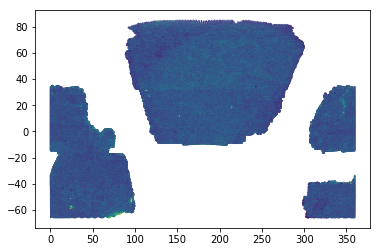

In [180]:
#let's take a look at the density
mg = len(relg)/len(felg)
print(mg)
wp = pixlr > 0
pixls = []
for i in range(0,len(pixlr)):
    if pixlr[i] > 0:
        pixls.append(i)
pixls = np.array(pixls).astype(int)        
th,phi = healpy.pix2ang(nside,pixls,nest=nest)
od = pixlg[wp]/pixlr[wp]/mg
def thphi2radec(theta,phi):
    return 180./np.pi*phi,-(180./np.pi*theta-90)
ra,dec = thphi2radec(th,phi)
plt.scatter(ra,dec,c=od,vmax=4,s=.1)
plt.show()

In [32]:
#let's define split into bmzls, DECaLS North, DECaLS South (Anand has tools to make distinct DES region as well)
def splitcat(cat):
    NN = cat['PHOTSYS'] == b'N'
    d1 = (cat['PHOTSYS'] != b'N') & (cat['RA'] < 300) & (cat['RA'] > 100) & (cat['DEC'] > -20)
    d2 = (d1==0) & (NN ==0) & (cat['DEC'] > -30)
    return cat[NN],cat[d1],cat[d2]
d1,d2,d3 = splitcat(felg)
r1,r2,r3 = splitcat(relg)

In [12]:
#return only logic so can be applied to columns generated on full sample downstream
#desply     = os.getenv('CSCRATCH')+'/desits/des.ply' #this doesn't work right now

def splitcat_logic(cat):
    NN = cat['PHOTSYS'] == b'N'
    d1 = (cat['PHOTSYS'] != b'N') & (cat['RA'] < 300) & (cat['RA'] > 100) & (cat['DEC'] > -20)
    d2 = (d1==0) & (NN ==0) & (cat['DEC'] > -30)
    return NN,d1,d2
sd1,sd2,sd3 = splitcat_logic(felg)
print(len(felg[sd1]),len(felg[sd2]),len(felg[sd3]))
sr1,sr2,sr3 = splitcat_logic(relg)

12726178 14094848 13407623


In [13]:
#turn plotting into function and plot each region separately
#could make this quicker by storing region info somewhere
def plotdens(dat,ran,nside=nside,nest=nest,vmax=4,wrapra=False):
    pixlr = np.zeros(12*nside*nside)
    pixlg = np.zeros(12*nside*nside)
    rth,rphi = radec2thphi(ran['RA'],ran['DEC'])
    rpix = hp.ang2pix(nside,rth,rphi,nest=nest)
    dth,dphi = radec2thphi(dat['RA'],dat['DEC'])
    dpix = hp.ang2pix(nside,dth,dphi,nest)
    for pix in rpix:
        pixlr[pix] += 1.
    print('randoms done')
    for pix in dpix:
        pixlg[pix] += 1.
    mg = len(ran)/len(dat)
    print(mg)
    wp = pixlr > 0
    pixls = []
    for i in range(0,len(pixlr)):
        if pixlr[i] > 0:
            pixls.append(i)
    pixls = np.array(pixls).astype(int)        
    th,phi = hp.pix2ang(nside,pixls,nest=nest)
    od = pixlg[wp]/pixlr[wp]*mg
    def thphi2radec(theta,phi):
        return 180./np.pi*phi,-(180./np.pi*theta-90)
    ra,dec = thphi2radec(th,phi)
    ranew = ra
    if wrapra:
        w = ra > 180.
        ranew[w] -= 360
    plt.scatter(ranew,dec,c=od,vmax=vmax,s=.1)
    plt.show()

randoms done
0.9296606569545075


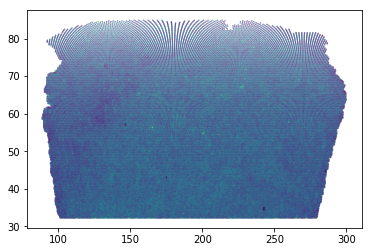

In [186]:
plotdens(d1,r1) 

randoms done
0.9516077080079189


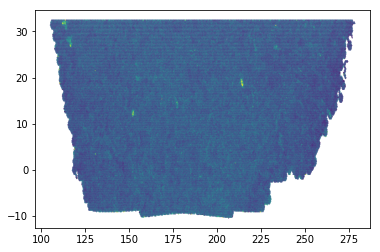

In [192]:
plotdens(d2,r2)

randoms done
0.9887929426416598


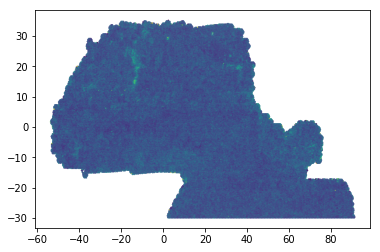

In [191]:
plotdens(d3,r3,wrapra=True)

In [ ]:
print('t')

In [13]:
#histograms for selection cuts
from matplotlib import pyplot as plt
gfluxc = felg['FLUX_G']/felg['MW_TRANSMISSION_G']
rfluxc = felg['FLUX_R']/felg['MW_TRANSMISSION_R']
zfluxc = felg['FLUX_Z']/felg['MW_TRANSMISSION_Z']

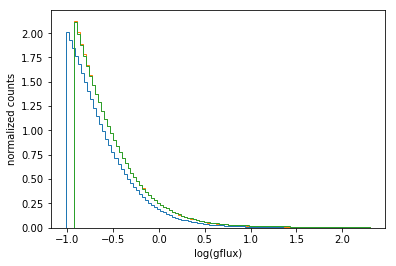

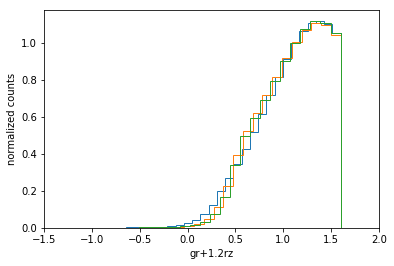

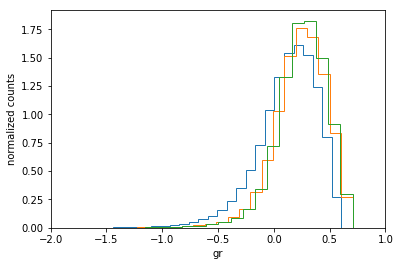

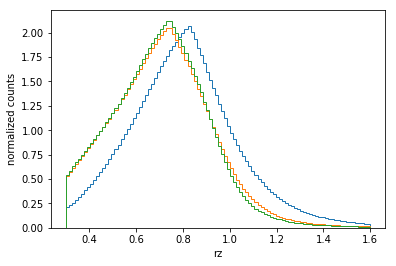

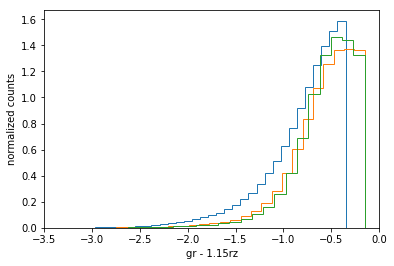

In [27]:
#histograms of counts as a function of cuts
gr = -2.5*np.log10(gfluxc / rfluxc)
rz = -2.5*np.log10(rfluxc / zfluxc)
plt.hist(np.log(gfluxc[sd1]),bins=100,normed=True,histtype='step')
plt.hist(np.log(gfluxc[sd2]),bins=100,normed=True,histtype='step')
plt.hist(np.log(gfluxc[sd3]),bins=100,normed=True,histtype='step')
plt.xlabel('log(gflux)')
plt.ylabel('normalized counts')
plt.show()
plt.hist(gr[sd1]+1.2*rz[sd1],bins=100,normed=True,histtype='step')
plt.hist(gr[sd2]+1.2*rz[sd2],bins=100,normed=True,histtype='step')
plt.hist(gr[sd3]+1.2*rz[sd3],bins=100,normed=True,histtype='step')
plt.xlim(-1.5,2)
plt.xlabel('gr+1.2rz')
plt.ylabel('normalized counts')
plt.show()
plt.hist(gr[sd1],bins=100,normed=True,histtype='step')
plt.hist(gr[sd2],bins=100,normed=True,histtype='step')
plt.hist(gr[sd3],bins=100,normed=True,histtype='step')
plt.xlabel('gr')
plt.ylabel('normalized counts')
plt.xlim(-2,1)
plt.show()

plt.hist(rz[sd1],bins=100,normed=True,histtype='step')
plt.hist(rz[sd2],bins=100,normed=True,histtype='step')
plt.hist(rz[sd3],bins=100,normed=True,histtype='step')
plt.xlabel('rz')
plt.ylabel('normalized counts')
plt.show()
plt.hist(gr[sd1]-1.15*rz[sd1],bins=100,normed=True,histtype='step')
plt.hist(gr[sd2]-1.15*rz[sd2],bins=100,normed=True,histtype='step')
plt.hist(gr[sd3]-1.15*rz[sd3],bins=100,normed=True,histtype='step')
plt.xlabel('gr - 1.15rz')
plt.ylabel('normalized counts')
plt.xlim(-3.5,0)
plt.show()

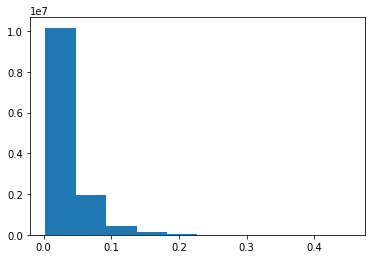

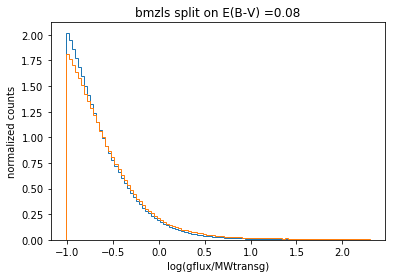

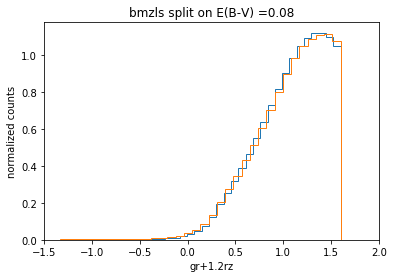

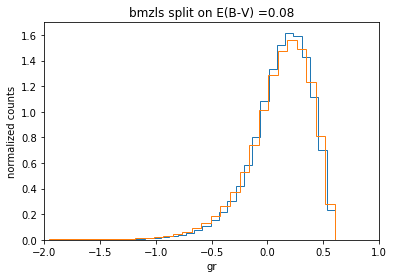

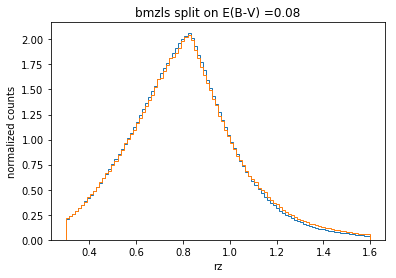

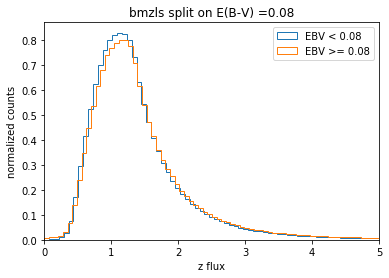

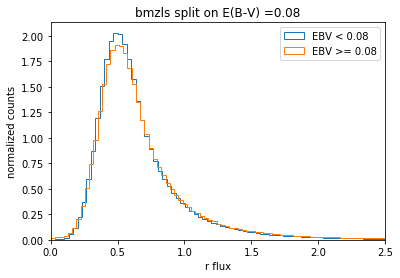

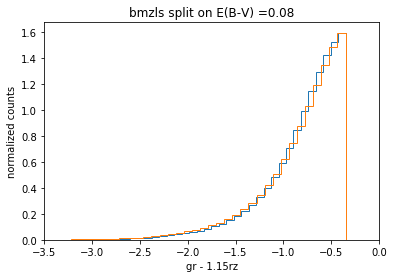

In [122]:
#Look at similar, but split into high and low extinction, bmzls first
plt.hist(d1['EBV'])
plt.show()

lebv = felg[sd1]['EBV'] < 0.08
plt.hist(np.log(gfluxc[sd1][lebv]),bins=100,normed=True,histtype='step')
plt.hist(np.log(gfluxc[sd1][~lebv]),bins=100,normed=True,histtype='step')
plt.xlabel('log(gflux/MWtransg)')
plt.ylabel('normalized counts')
plt.title('bmzls split on E(B-V) =0.08')
plt.show()
plt.hist(gr[sd1][lebv]+1.2*rz[sd1][lebv],bins=100,normed=True,histtype='step')
plt.hist(gr[sd1][~lebv]+1.2*rz[sd1][~lebv],bins=100,normed=True,histtype='step')
plt.xlim(-1.5,2)
plt.xlabel('gr+1.2rz')
plt.ylabel('normalized counts')
plt.title('bmzls split on E(B-V) =0.08')
plt.show()
plt.hist(gr[sd1][lebv],bins=100,normed=True,histtype='step')
plt.hist(gr[sd1][~lebv],bins=100,normed=True,histtype='step')
plt.xlabel('gr')
plt.ylabel('normalized counts')
plt.title('bmzls split on E(B-V) =0.08')
plt.xlim(-2,1)
plt.show()

plt.hist(rz[sd1][lebv],bins=100,normed=True,histtype='step')
plt.hist(rz[sd1][~lebv],bins=100,normed=True,histtype='step')
plt.xlabel('rz')
plt.ylabel('normalized counts')
plt.title('bmzls split on E(B-V) =0.08')
plt.show()

plt.hist(zfluxc[sd1][lebv],bins=500,normed=True,histtype='step')
plt.hist(zfluxc[sd1][~lebv],bins=500,normed=True,histtype='step')
plt.xlabel('z flux')
plt.ylabel('normalized counts')
plt.legend((['EBV < 0.08','EBV >= 0.08']))
plt.title('bmzls split on E(B-V) =0.08')
plt.xlim(0,5)
plt.show()

plt.hist(rfluxc[sd1][lebv],bins=500,normed=True,histtype='step')
plt.hist(rfluxc[sd1][~lebv],bins=500,normed=True,histtype='step')
plt.xlabel('r flux')
plt.ylabel('normalized counts')
plt.legend((['EBV < 0.08','EBV >= 0.08']))
plt.title('bmzls split on E(B-V) =0.08')
plt.xlim(0,2.5)
plt.show()


plt.hist(gr[sd1][lebv]-1.15*rz[sd1][lebv],bins=100,normed=True,histtype='step')
plt.hist(gr[sd1][~lebv]-1.15*rz[sd1][~lebv],bins=100,normed=True,histtype='step')
plt.xlabel('gr - 1.15rz')
plt.ylabel('normalized counts')
plt.xlim(-3.5,0)
plt.title('bmzls split on E(B-V) =0.08')
plt.show()

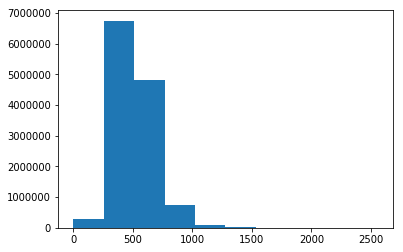

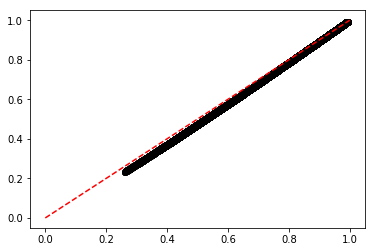

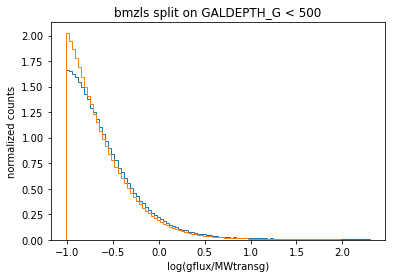

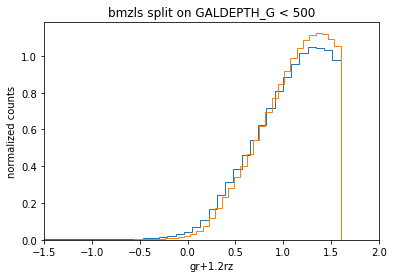

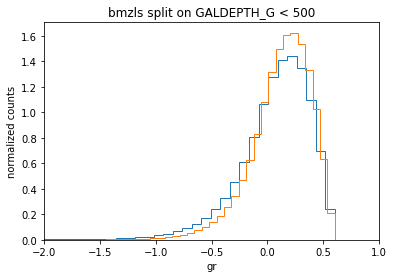

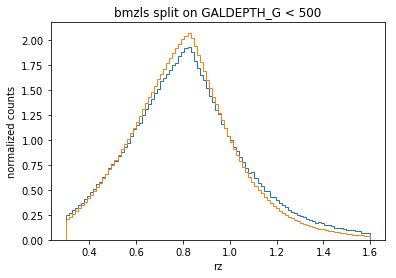

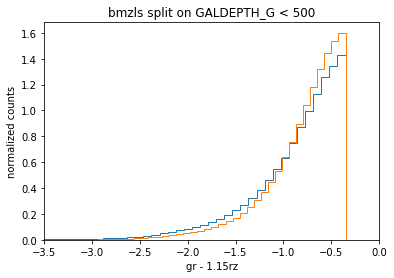

In [58]:
#split on g depth
plt.hist(d1['GALDEPTH_G'])
plt.show()
plt.plot(d1['MW_TRANSMISSION_G'],np.exp(-3.214*d1['EBV']),'ko')
plt.plot([0,1],[0,1],'r--')
plt.show()
lebv = felg[sd1]['GALDEPTH_G'] < 300
plt.hist(np.log(gfluxc[sd1][lebv]),bins=100,normed=True,histtype='step')
plt.hist(np.log(gfluxc[sd1][~lebv]),bins=100,normed=True,histtype='step')
plt.xlabel('log(gflux/MWtransg)')
plt.ylabel('normalized counts')
plt.title('bmzls split on GALDEPTH_G < 500')
plt.show()
plt.hist(gr[sd1][lebv]+1.2*rz[sd1][lebv],bins=100,normed=True,histtype='step')
plt.hist(gr[sd1][~lebv]+1.2*rz[sd1][~lebv],bins=100,normed=True,histtype='step')
plt.xlim(-1.5,2)
plt.xlabel('gr+1.2rz')
plt.ylabel('normalized counts')
plt.title('bmzls split on GALDEPTH_G < 500')
plt.show()
plt.hist(gr[sd1][lebv],bins=100,normed=True,histtype='step')
plt.hist(gr[sd1][~lebv],bins=100,normed=True,histtype='step')
plt.xlabel('gr')
plt.ylabel('normalized counts')
plt.title('bmzls split on GALDEPTH_G < 500')
plt.xlim(-2,1)
plt.show()

plt.hist(rz[sd1][lebv],bins=100,normed=True,histtype='step')
plt.hist(rz[sd1][~lebv],bins=100,normed=True,histtype='step')
plt.xlabel('rz')
plt.ylabel('normalized counts')
plt.title('bmzls split on GALDEPTH_G < 500')
plt.show()

plt.hist(gr[sd1][lebv]-1.15*rz[sd1][lebv],bins=100,normed=True,histtype='step')
plt.hist(gr[sd1][~lebv]-1.15*rz[sd1][~lebv],bins=100,normed=True,histtype='step')
plt.xlabel('gr - 1.15rz')
plt.ylabel('normalized counts')
plt.xlim(-3.5,0)
plt.title('bmzls split on GALDEPTH_G < 500')
plt.show()

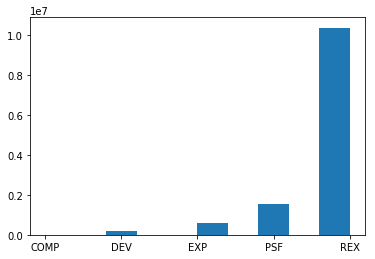

In [19]:
#histograms for morphological type
from matplotlib import pyplot as plt
plt.hist(d1['MORPHTYPE'])
plt.title('bmzls morphtype')
plt.show()

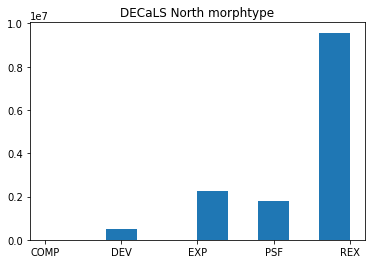

In [20]:
plt.hist(d2['MORPHTYPE'])
plt.title('DECaLS North morphtype')
plt.show()


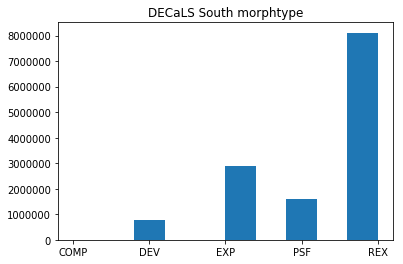

In [22]:
plt.hist(d3['MORPHTYPE'])
plt.title('DECaLS South morphtype')
plt.show()


In [26]:
print(np.unique(d1['MORPHTYPE']))
w1 = d1['MORPHTYPE'] == b'EXP'
print(len(d1[w1]))

[b'COMP' b'DEV' b'EXP' b'PSF' b'REX']
600204


In [40]:
def plotvsebv_morphtype(r1,d1,reg=''):
    morphl = np.unique(d1['MORPHTYPE'])
    for mp in morphl:
        w1 = d1['MORPHTYPE'] == mp
        w1 &= d1['EBV'] < 0.15 #mask applied to (e)BOSS
        mr = r1['EBV'] < 0.15
        hd1 = np.histogram(d1[w1]['EBV'])
        print(hd1)
        hr1 = np.histogram(r1[mr]['EBV'],bins=hd1[1])
        print(hr1)
        xl = []
        for i in range(0,len(hd1[0])):
            xl.append((hd1[1][i]+hd1[1][i+1])/2.)
        plt.errorbar(xl,hd1[0]/hr1[0],np.sqrt(hd1[0])/hr1[0],fmt='ko')
        plt.title(str(mp)+reg)
        plt.ylabel('relative density')
        plt.xlabel('E(B-V)')
        plt.show()    

(array([397, 252, 120,  79,  49,  28,  17,  21,   9,  10]), array([ 0.00414243,  0.01837215,  0.03260186,  0.04683158,  0.06106129,
        0.07529101,  0.08952072,  0.10375044,  0.11798015,  0.13220987,
        0.14643958]))
(array([4719309, 2832289, 1541866, 1049802,  584813,  344049,  232502,
        172816,  112225,   91644]), array([ 0.00414243,  0.01837215,  0.03260186,  0.04683158,  0.06106129,
        0.07529101,  0.08952072,  0.10375044,  0.11798015,  0.13220987,
        0.14643958]))


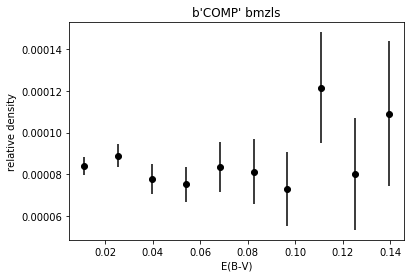

(array([79879, 58376, 28321, 19199, 10041,  5934,  4337,  3003,  2032,  1644]), array([ 0.00260759,  0.01734612,  0.03208464,  0.04682317,  0.0615617 ,
        0.07630022,  0.09103875,  0.10577727,  0.1205158 ,  0.13525433,
        0.14999285]))
(array([4312404, 3178107, 1605621, 1077908,  588174,  341057,  234105,
        166315,  110245,   89798]), array([ 0.00260759,  0.01734612,  0.03208464,  0.04682317,  0.0615617 ,
        0.07630022,  0.09103875,  0.10577727,  0.1205158 ,  0.13525433,
        0.14999285]))


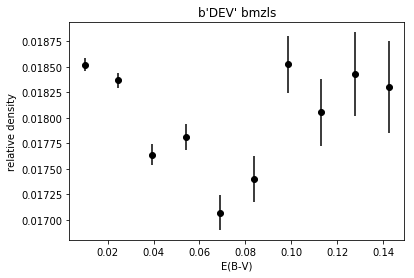

(array([234600, 172855,  77023,  51690,  25727,  13511,   8853,   5938,
         3688,   3086]), array([ 0.00238167,  0.017142  ,  0.03190233,  0.04666265,  0.06142298,
        0.07618331,  0.09094364,  0.10570397,  0.1204643 ,  0.13522463,
        0.14998496]))
(array([4226692, 3241256, 1613569, 1085027,  592190,  342884,  234752,
        166925,  110466,   89971]), array([ 0.00238167,  0.017142  ,  0.03190233,  0.04666265,  0.06142298,
        0.07618331,  0.09094364,  0.10570397,  0.1204643 ,  0.13522463,
        0.14998496]))


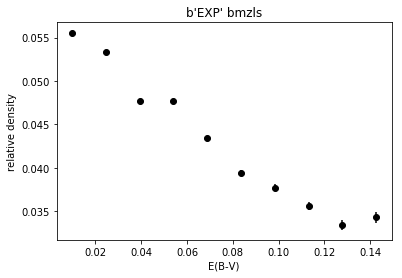

(array([534242, 424054, 214723, 137132,  72749,  42935,  29749,  20822,
        14355,  11839]), array([ 0.00243648,  0.01719263,  0.03194879,  0.04670495,  0.0614611 ,
        0.07621726,  0.09097341,  0.10572957,  0.12048573,  0.13524188,
        0.14999804]))
(array([4248054, 3225720, 1611679, 1083206,  591081,  342401,  234573,
        166774,  110383,   89913]), array([ 0.00243648,  0.01719263,  0.03194879,  0.04670495,  0.0614611 ,
        0.07621726,  0.09097341,  0.10572957,  0.12048573,  0.13524188,
        0.14999804]))


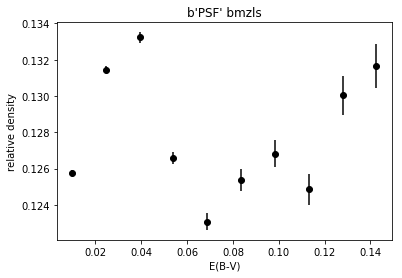

(array([3914546, 2978590, 1378657,  892440,  458828,  257426,  173117,
        118657,   76706,   60865]), array([ 0.0023301 ,  0.01709708,  0.03186406,  0.04663104,  0.06139802,
        0.076165  ,  0.09093198,  0.10569896,  0.12046594,  0.13523292,
        0.1499999 ]))
(array([4207425, 3255818, 1615373, 1086524,  593080,  343184,  234915,
        167000,  110511,   89974]), array([ 0.0023301 ,  0.01709708,  0.03186406,  0.04663104,  0.06139802,
        0.076165  ,  0.09093198,  0.10569896,  0.12046594,  0.13523292,
        0.1499999 ]))


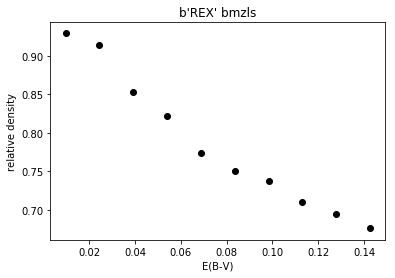

(array([ 549, 1377,  803,  347,  171,  108,   59,   39,   34,   23]), array([ 0.00757006,  0.02179781,  0.03602557,  0.05025332,  0.06448108,
        0.07870884,  0.09293659,  0.10716435,  0.1213921 ,  0.13561986,
        0.14984761]))
(array([2183984, 5275268, 3119903, 1327054,  607700,  326274,  209985,
        122740,   87649,   62246]), array([ 0.00757006,  0.02179781,  0.03602557,  0.05025332,  0.06448108,
        0.07870884,  0.09293659,  0.10716435,  0.1213921 ,  0.13561986,
        0.14984761]))


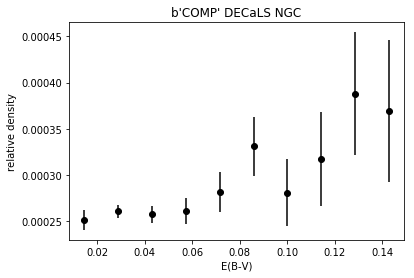

(array([ 74084, 206646, 117850,  46751,  20884,  11345,   6609,   3567,
         2531,   1804]), array([ 0.00671232,  0.02104093,  0.03536953,  0.04969813,  0.06402673,
        0.07835533,  0.09268393,  0.10701253,  0.12134113,  0.13566974,
        0.14999834]))
(array([1905290, 5362845, 3233648, 1376346,  626409,  331692,  213055,
        124097,   88269,   62519]), array([ 0.00671232,  0.02104093,  0.03536953,  0.04969813,  0.06402673,
        0.07835533,  0.09268393,  0.10701253,  0.12134113,  0.13566974,
        0.14999834]))


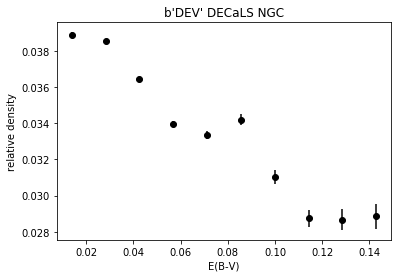

(array([310729, 967444, 554429, 210392,  90244,  45929,  27085,  14101,
         9481,   6343]), array([ 0.00624402,  0.02061942,  0.03499482,  0.04937022,  0.06374563,
        0.07812103,  0.09249643,  0.10687183,  0.12124723,  0.13562264,
        0.14999804]))
(array([1757879, 5397780, 3298456, 1405483,  638221,  334966,  214944,
        125036,   88698,   62766]), array([ 0.00624402,  0.02061942,  0.03499482,  0.04937022,  0.06374563,
        0.07812103,  0.09249643,  0.10687183,  0.12124723,  0.13562264,
        0.14999804]))


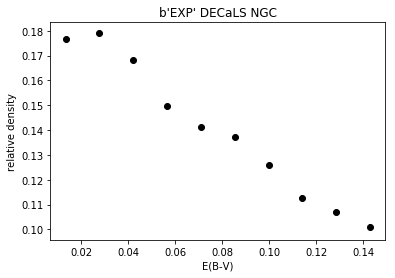

(array([227178, 701469, 436893, 192128,  88816,  47811,  31014,  18470,
        13800,   9950]), array([ 0.00637411,  0.02073664,  0.03509917,  0.0494617 ,  0.06382423,
        0.07818676,  0.09254929,  0.10691182,  0.12127435,  0.13563688,
        0.14999941]))
(array([1798544, 5388756, 3280295, 1397165,  635008,  333989,  214429,
        124784,   88561,   62686]), array([ 0.00637411,  0.02073664,  0.03509917,  0.0494617 ,  0.06382423,
        0.07818676,  0.09254929,  0.10691182,  0.12127435,  0.13563688,
        0.14999941]))


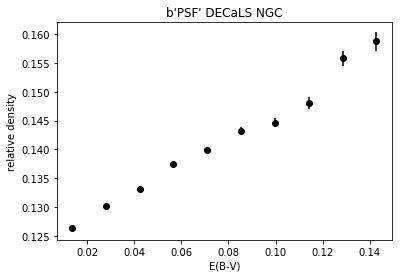

(array([1180186, 3970342, 2438922,  988297,  421839,  210571,  130685,
         77116,   56233,   40819]), array([ 0.0058847 ,  0.02029618,  0.03470766,  0.04911915,  0.06353063,
        0.07794211,  0.0923536 ,  0.10676508,  0.12117656,  0.13558805,
        0.14999953]))
(array([1648094, 5420360, 3348569, 1428341,  647316,  337390,  216395,
        125771,   89057,   62953]), array([ 0.0058847 ,  0.02029618,  0.03470766,  0.04911915,  0.06353063,
        0.07794211,  0.0923536 ,  0.10676508,  0.12117656,  0.13558805,
        0.14999953]))


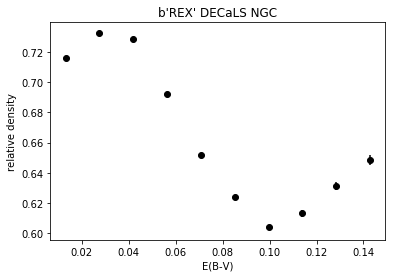

(array([1910, 2691, 1459,  769,  528,  368,  231,  158,   91,   47]), array([ 0.00661878,  0.02091772,  0.03521667,  0.04951561,  0.06381456,
        0.0781135 ,  0.09241245,  0.10671139,  0.12101033,  0.13530928,
        0.14960822]))
(array([1392492, 2711866, 2517486, 2082085, 1504536, 1063436,  705586,
        447606,  264664,  166446]), array([ 0.00661878,  0.02091772,  0.03521667,  0.04951561,  0.06381456,
        0.0781135 ,  0.09241245,  0.10671139,  0.12101033,  0.13530928,
        0.14960822]))


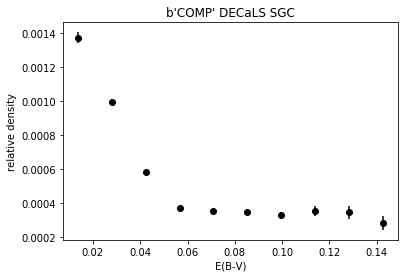

(array([114418, 214098, 147138,  99539,  67595,  46765,  31368,  19780,
        12271,   7824]), array([ 0.00523935,  0.01971485,  0.03419034,  0.04866584,  0.06314133,
        0.07761682,  0.09209232,  0.10656781,  0.12104331,  0.1355188 ,
        0.1499943 ]))
(array([1194709, 2706236, 2579289, 2139644, 1545027, 1088265,  719316,
        454096,  266812,  167057]), array([ 0.00523935,  0.01971485,  0.03419034,  0.04866584,  0.06314133,
        0.07761682,  0.09209232,  0.10656781,  0.12104331,  0.1355188 ,
        0.1499943 ]))


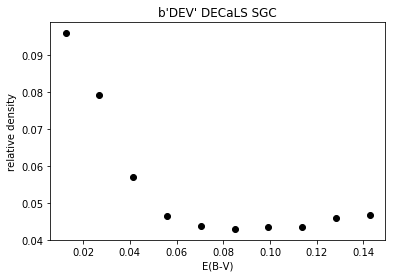

(array([396020, 793136, 578931, 398446, 264832, 171842, 109490,  66395,
        37998,  23236]), array([ 0.00504984,  0.01954472,  0.0340396 ,  0.04853448,  0.06302936,
        0.07752424,  0.09201912,  0.106514  ,  0.12100888,  0.13550376,
        0.14999864]))
(array([1166433, 2703978, 2587433, 2147559, 1551011, 1092194,  721757,
        455401,  267444,  167291]), array([ 0.00504984,  0.01954472,  0.0340396 ,  0.04853448,  0.06302936,
        0.07752424,  0.09201912,  0.106514  ,  0.12100888,  0.13550376,
        0.14999864]))


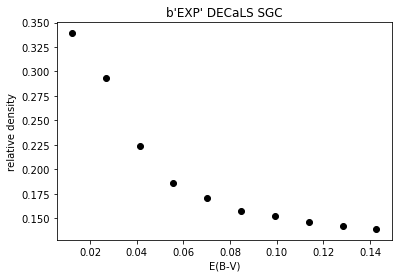

(array([104044, 275039, 313860, 280416, 208831, 152389, 101192,  63048,
        36763,  23269]), array([ 0.00541505,  0.0198734 ,  0.03433175,  0.04879011,  0.06324846,
        0.07770682,  0.09216517,  0.10662353,  0.12108188,  0.13554024,
        0.14999859]))
(array([1220954, 2708763, 2571418, 2132661, 1539220, 1084504,  717179,
        452800,  266198,  166780]), array([ 0.00541505,  0.0198734 ,  0.03433175,  0.04879011,  0.06324846,
        0.07770682,  0.09216517,  0.10662353,  0.12108188,  0.13554024,
        0.14999859]))


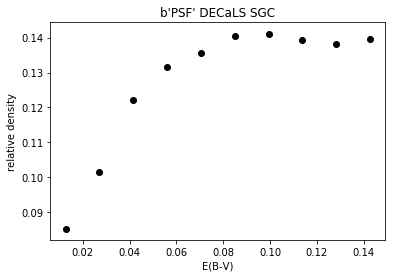

(array([ 533616, 1411865, 1545174, 1361352, 1012100,  729003,  499033,
        325350,  201191,  132711]), array([ 0.00503998,  0.01953597,  0.03403197,  0.04852796,  0.06302396,
        0.07751996,  0.09201595,  0.10651195,  0.12100794,  0.13550394,
        0.14999993]))
(array([1164987, 2703924, 2587793, 2148018, 1551280, 1092407,  721882,
        455456,  267464,  167298]), array([ 0.00503998,  0.01953597,  0.03403197,  0.04852796,  0.06302396,
        0.07751996,  0.09201595,  0.10651195,  0.12100794,  0.13550394,
        0.14999993]))


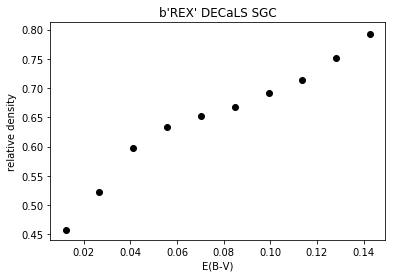

In [41]:
plotvsebv_morphtype(r1,d1,reg=' bmzls')
plotvsebv_morphtype(r2,d2,reg=' DECaLS NGC')
plotvsebv_morphtype(r3,d3,reg=' DECaLS SGC')

In [49]:
def plotfracMorphvsebv(r1,d1,reg=''):
    for mp in morphl:
        w1 = d1['MORPHTYPE'] == mp
        w1 &= d1['EBV'] < 0.15 #mask applied to (e)BOSS
        w = d1['EBV'] < 0.15 #mask applied to (e)BOSS
        hd1 = np.histogram(d1[w1]['EBV'])
        #print(hd1)
        hr1 = np.histogram(d1[w]['EBV'],bins=hd1[1])
        #print(hr1)
        xl = []
        for i in range(0,len(hd1[0])):
            xl.append((hd1[1][i]+hd1[1][i+1])/2.)
        plt.errorbar(xl,hd1[0]/hr1[0],np.sqrt(hd1[0])/hr1[0],fmt='ko')
        plt.title(reg)
        plt.ylabel('fraction '+str(mp))
        plt.xlabel('E(B-V)')
        plt.show()    

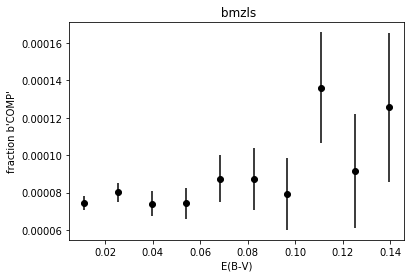

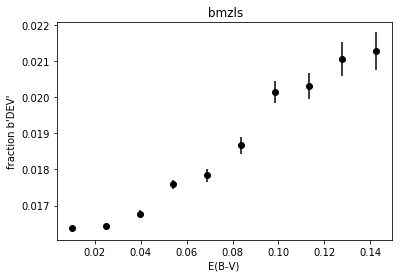

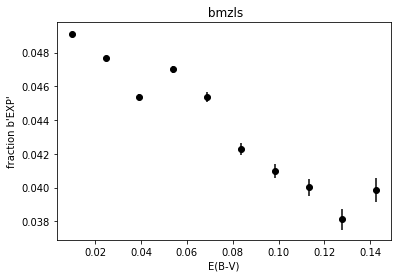

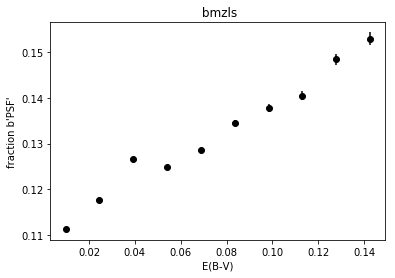

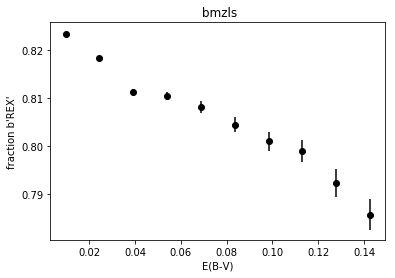

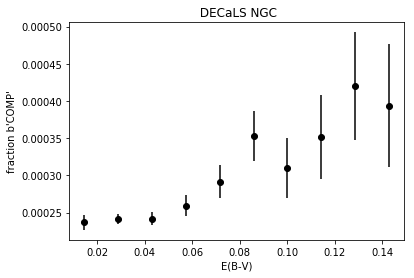

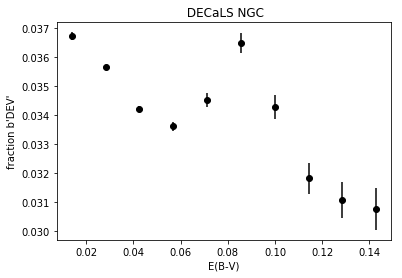

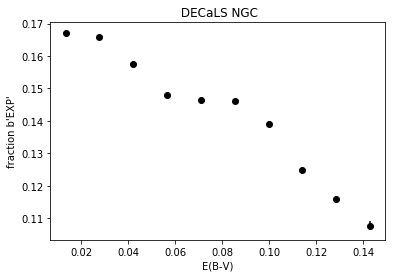

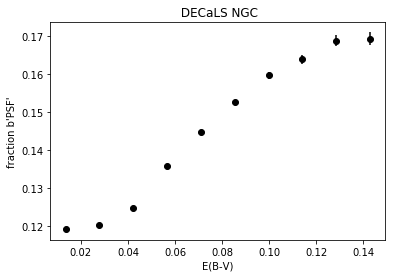

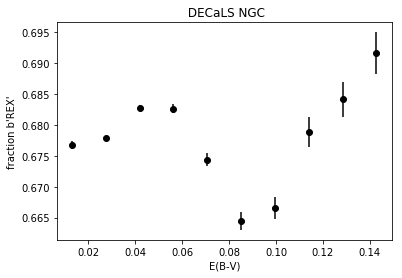

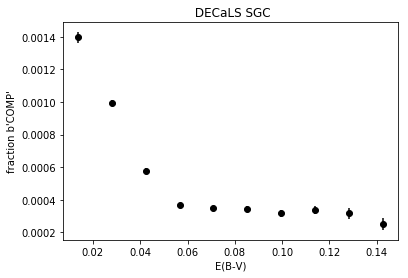

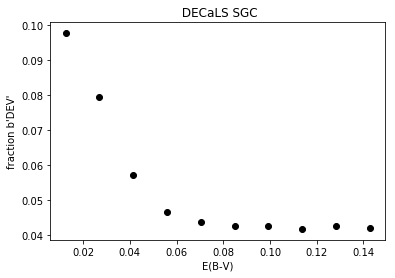

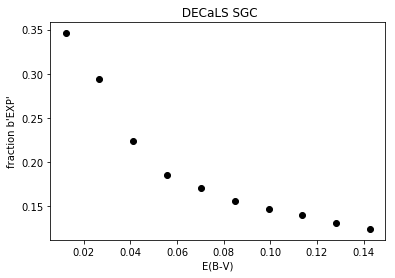

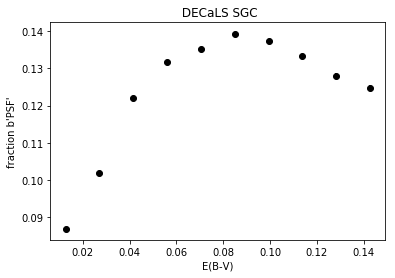

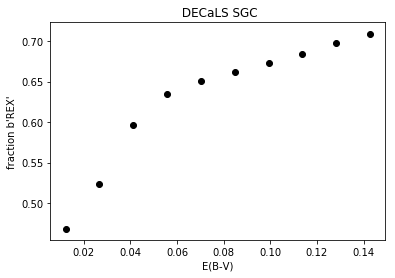

In [50]:
plotfracMorphvsebv(r1,d1,reg=' bmzls')
plotfracMorphvsebv(r2,d2,reg=' DECaLS NGC')
plotfracMorphvsebv(r3,d3,reg=' DECaLS SGC')

In [46]:
def plotfracEXPvsdepth(r1,d1,reg=''):
    depthl = ['PSFDEPTH_G', 'PSFDEPTH_R', 'PSFDEPTH_Z']
    for depth in depthl:
        w1 = d1['MORPHTYPE'] == b'EXP'
        w1 &= d1['EBV'] < 0.15 #mask applied to (e)BOSS
        w = d1['EBV'] < 0.15 #mask applied to (e)BOSS
        hd1 = np.histogram(d1[w1][depth])
        #print(hd1)
        hr1 = np.histogram(d1[w][depth],bins=hd1[1])
        #print(hr1)
        xl = []
        for i in range(0,len(hd1[0])):
            xl.append((hd1[1][i]+hd1[1][i+1])/2.)
        plt.errorbar(xl,hd1[0]/hr1[0],np.sqrt(hd1[0])/hr1[0],fmt='ko')
        plt.title(reg)
        plt.ylabel('fraction EXP')
        plt.xlabel(depth)
        plt.show()    

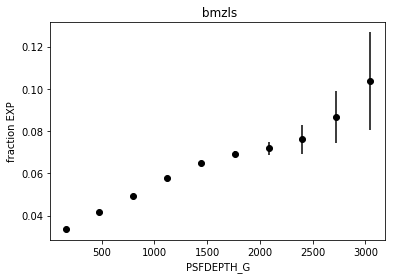

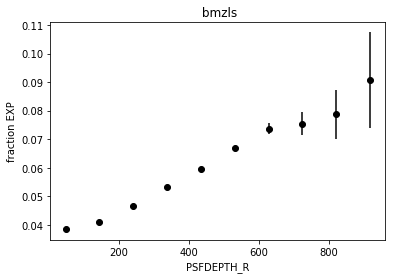

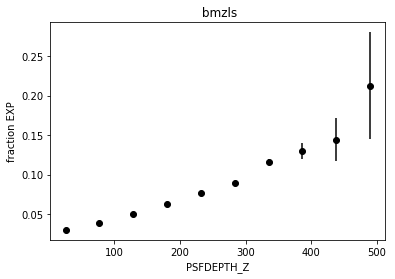

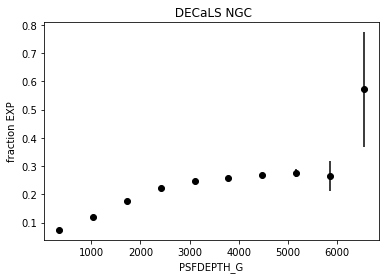

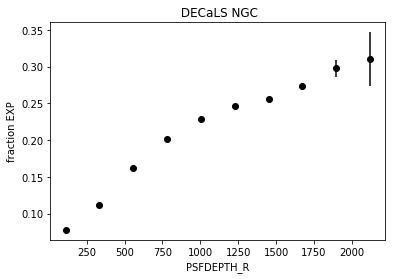

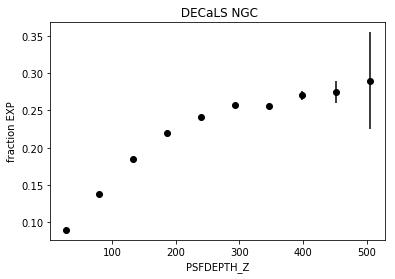

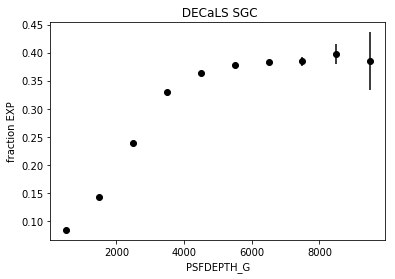

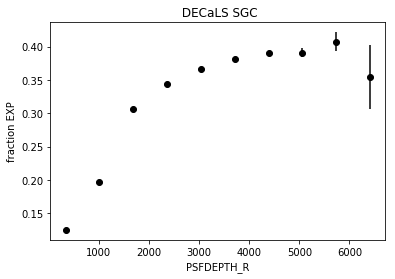

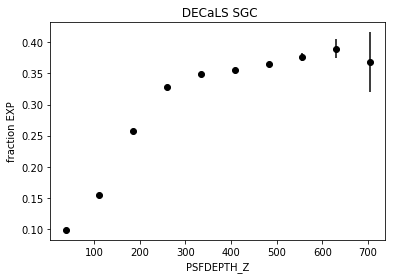

In [47]:
plotfracEXPvsdepth(r1,d1,reg=' bmzls')
plotfracEXPvsdepth(r2,d2,reg=' DECaLS NGC')
plotfracEXPvsdepth(r3,d3,reg=' DECaLS SGC')

(array([  1.70000000e+01,   1.03000000e+02,   6.58000000e+02,
          2.84300000e+03,   3.70160000e+04,   2.88618600e+06,
          8.50137300e+06,   1.20175500e+06,   8.90340000e+04,
          7.19300000e+03]),
 array([-2.46981287, -2.06797252, -1.66613216, -1.26429181, -0.86245146,
        -0.4606111 , -0.05877075,  0.3430696 ,  0.74490995,  1.14675031,
         1.54859066]),
 <a list of 10 Patch objects>)

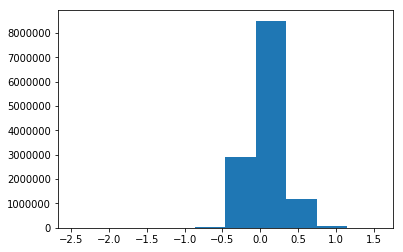

In [84]:
plt.hist(np.log10(d1['FLUX_Z']))

In [103]:
#wd = (d1['GALDEPTH_G']*np.exp(-3.214*d1['EBV']) > 300)
#rgtrans = get_pixkey(rpix[sr1],'MW_TRANSMISSION_G')
#wr = (r1['GALDEPTH_G']*np.exp(-3.214*r1['EBV'])>300) 
wd = np.log10(d1['FLUX_Z']) < 0
plotdens(d1[wd],r1,vmax=2) 
plotdens(d1,r1,vmax=2)

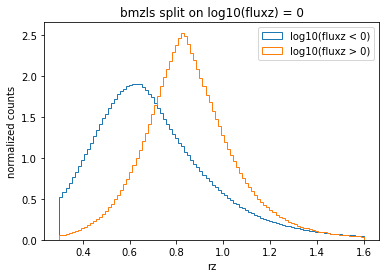

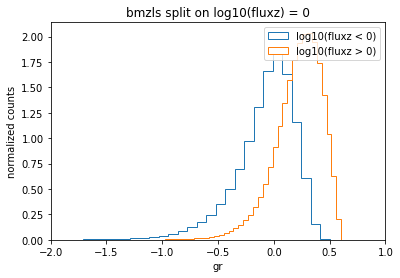

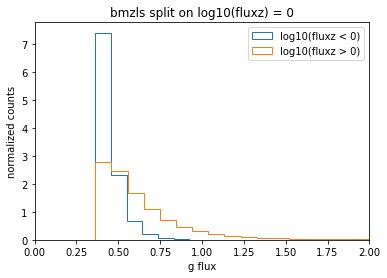

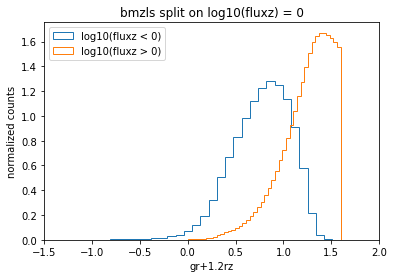

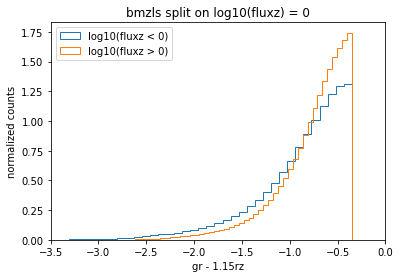

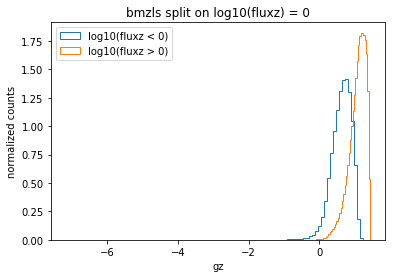

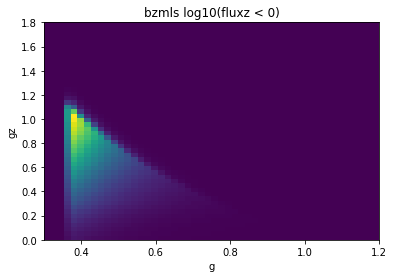

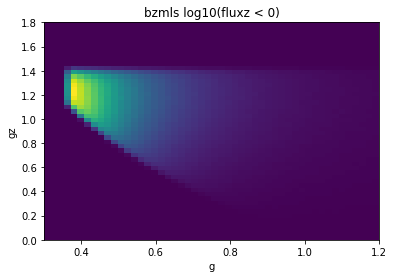

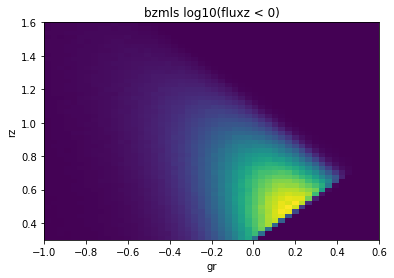

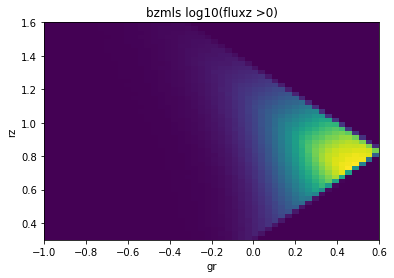

In [149]:
wd = np.log10(d1['FLUX_Z']) < 0
plt.hist(rz[sd1][wd],bins=100,normed=True,histtype='step')
plt.hist(rz[sd1][~wd],bins=100,normed=True,histtype='step')
plt.xlabel('rz')
plt.ylabel('normalized counts')
plt.title('bmzls split on log10(fluxz) = 0')
plt.legend((['log10(fluxz < 0)','log10(fluxz > 0)']))
plt.show()
plt.hist(gr[sd1][wd],bins=100,normed=True,histtype='step')
plt.hist(gr[sd1][~wd],bins=100,normed=True,histtype='step')
plt.xlabel('gr')
plt.ylabel('normalized counts')
plt.title('bmzls split on log10(fluxz) = 0')
plt.legend((['log10(fluxz < 0)','log10(fluxz > 0)']))
plt.xlim(-2,1)
plt.show()
plt.hist(gfluxc[sd1][wd],bins=100,normed=True,histtype='step')
plt.hist(gfluxc[sd1][~wd],bins=100,normed=True,histtype='step')
plt.xlabel('g flux')
plt.ylabel('normalized counts')
plt.title('bmzls split on log10(fluxz) = 0')
plt.legend((['log10(fluxz < 0)','log10(fluxz > 0)']))
plt.xlim(0,2)
plt.show()
plt.hist(gr[sd1][wd]+1.2*rz[sd1][wd],bins=100,normed=True,histtype='step')
plt.hist(gr[sd1][~wd]+1.2*rz[sd1][~wd],bins=100,normed=True,histtype='step')
plt.xlim(-1.5,2)
plt.xlabel('gr+1.2rz')
plt.ylabel('normalized counts')
plt.legend((['log10(fluxz < 0)','log10(fluxz > 0)']),loc='upper left')
plt.title('bmzls split on log10(fluxz) = 0')
plt.show()
plt.hist(gr[sd1][wd]-1.15*rz[sd1][wd],bins=100,normed=True,histtype='step')
plt.hist(gr[sd1][~wd]-1.15*rz[sd1][~wd],bins=100,normed=True,histtype='step')
plt.xlabel('gr - 1.15rz')
plt.ylabel('normalized counts')
plt.xlim(-3.5,0)
plt.legend((['log10(fluxz < 0)','log10(fluxz > 0)']),loc='upper left')
plt.title('bmzls split on log10(fluxz) = 0')
plt.show()

gz = -2.5*np.log10(gfluxc / zfluxc)
plt.hist(gz[sd1][wd],bins=100,normed=True,histtype='step')
plt.hist(gz[sd1][~wd],bins=100,normed=True,histtype='step')
plt.xlabel('gz')
plt.ylabel('normalized counts')
plt.title('bmzls split on log10(fluxz) = 0')
plt.legend((['log10(fluxz < 0)','log10(fluxz > 0)']))
plt.show()

plt.hist2d(gfluxc[sd1][wd],gz[sd1][wd],(50, 50),range=[[0.3,1.2],[0,1.8]])
plt.xlabel('g')
plt.ylabel('gz')
plt.title('bzmls log10(fluxz < 0)')

plt.show()

plt.hist2d(gfluxc[sd1][~wd],gz[sd1][~wd],(50, 50),range=[[0.3,1.2],[0,1.8]])
plt.xlabel('g')
plt.ylabel('gz')
plt.title('bzmls log10(fluxz < 0)')

plt.show()


plt.hist2d(gr[sd1][wd],rz[sd1][wd],(50, 50),range=[[-1,.6],[0.3,1.6]])
plt.xlabel('gr')
plt.ylabel('rz')
plt.title('bzmls log10(fluxz < 0)')

plt.show()

plt.hist2d(gr[sd1][~wd],rz[sd1][~wd],(50, 50),range=[[-1,.6],[0.3,1.6]])
plt.xlabel('gr')
plt.ylabel('rz')
plt.title('bzmls log10(fluxz >0)')

plt.show()

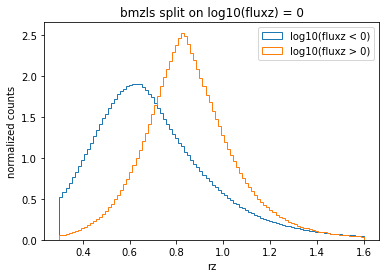

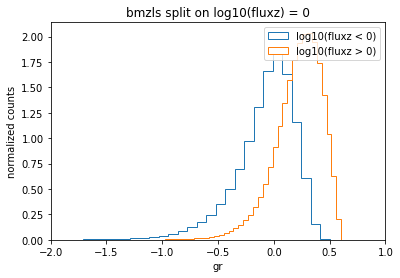

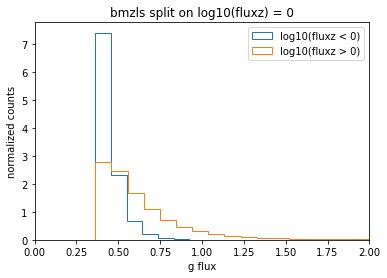

[0.0097180885612033301, 0.024484595202375201, 0.039251101843547076, 0.054017608484718954, 0.068784115125890818, 0.083550621767062697, 0.098317128408234561, 0.11308363504940644, 0.12785014169057832, 0.1426166483317502] [0.0097135419142432514, 0.02448043146869168, 0.039247321023140103, 0.054014210577588533, 0.068781100132036949, 0.083547989686485385, 0.098314879240933822, 0.11308176879538223, 0.12784865834983067, 0.14261554790427911]


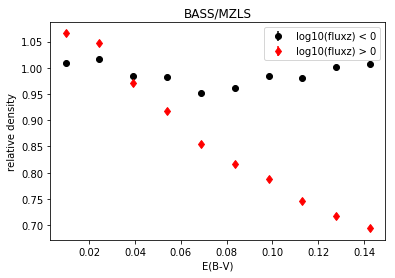

[35.161718749999999, 105.48515624999999, 175.80859375, 246.13203124999998, 316.45546875000002, 386.77890624999998, 457.10234374999993, 527.42578125, 597.74921874999995, 668.07265624999991] [35.161718749999999, 105.48515624999999, 175.80859375, 246.13203124999998, 316.45546875000002, 386.77890624999998, 457.10234374999993, 527.42578125, 597.74921874999995, 668.07265624999991]


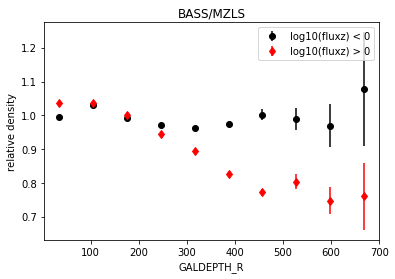

[125.79166259765626, 377.3749877929688, 628.95831298828125, 880.54163818359382, 1132.1249633789062, 1383.7082885742188, 1635.2916137695315, 1886.8749389648438, 2138.4582641601564, 2390.0415893554691] [125.17308349609375, 375.51925048828127, 625.86541748046875, 876.21158447265634, 1126.5577514648437, 1376.9039184570313, 1627.2500854492187, 1877.5962524414062, 2127.9424194335938, 2378.2885864257814]


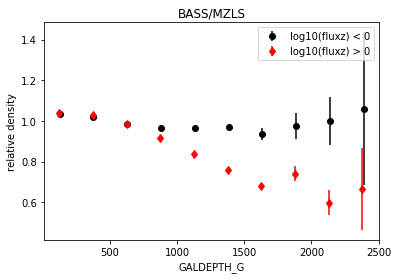

[13.075094604492188, 39.225283813476565, 65.375473022460938, 91.525662231445324, 117.67585144042968, 143.82604064941407, 169.97622985839843, 196.12641906738281, 222.2766082763672, 248.42679748535159] [13.618901062011719, 40.856703186035162, 68.094505310058594, 95.33230743408204, 122.57010955810547, 149.80791168212892, 177.04571380615238, 204.28351593017578, 231.52131805419924, 258.75912017822264]


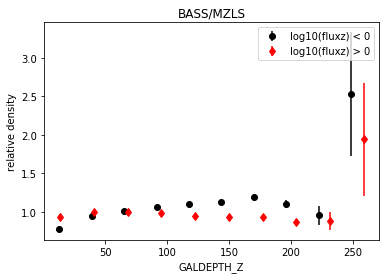

In [127]:
wd = np.log10(d1['FLUX_Z']) < 0
we = wd & (d1['EBV'] < 0.15)
wen = (wd == 0) & (d1['EBV'] < 0.15)
wr = r1['EBV'] < 0.15
hg1 = np.histogram(d1[we]['EBV'])
hr1 = np.histogram(r1[wr]['EBV'],bins=hg1[1])
hg2 = np.histogram(d1[wen]['EBV'])
hr2 = np.histogram(r1[wr]['EBV'],bins=hg2[1])
xl1 = []
xl2 = []
#print(hg1,hg2)
#print(hr1,hr2)
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
print(xl1,xl2)
norm1 = sum(hr1[0])/sum(hg1[0])
norm2 = sum(hr2[0])/sum(hg2[0])
plt.errorbar(xl1,hg1[0]/hr1[0]*norm1,np.sqrt(hg1[0])/hr1[0]*norm1,fmt='ko')
plt.errorbar(xl2,hg2[0]/hr2[0]*norm2,np.sqrt(hg2[0])/hr2[0]*norm2,fmt='rd')
#plt.ylim(.7,1.3)
plt.xlabel('E(B-V)')
plt.ylabel('relative density')
plt.legend((['log10(fluxz) < 0','log10(fluxz) > 0']))
plt.title('BASS/MZLS')
plt.show()
hg1 = np.histogram(d1[we]['GALDEPTH_R'])
hr1 = np.histogram(r1[wr]['GALDEPTH_R'],bins=hg1[1])
hg2 = np.histogram(d1[wen]['GALDEPTH_R'])
hr2 = np.histogram(r1[wr]['GALDEPTH_R'],bins=hg2[1])
xl1 = []
xl2 = []
#print(hg1,hg2)
#print(hr1,hr2)
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
print(xl1,xl2)
norm1 = sum(hr1[0])/sum(hg1[0])
norm2 = sum(hr2[0])/sum(hg2[0])
plt.errorbar(xl1,hg1[0]/hr1[0]*norm1,np.sqrt(hg1[0])/hr1[0]*norm1,fmt='ko')
plt.errorbar(xl2,hg2[0]/hr2[0]*norm2,np.sqrt(hg2[0])/hr2[0]*norm2,fmt='rd')
#plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_R')
plt.ylabel('relative density')
plt.legend((['log10(fluxz) < 0','log10(fluxz) > 0']))
plt.title('BASS/MZLS')
plt.show()
hg1 = np.histogram(d1[we]['GALDEPTH_G'])
hr1 = np.histogram(r1[wr]['GALDEPTH_G'],bins=hg1[1])
hg2 = np.histogram(d1[wen]['GALDEPTH_G'])
hr2 = np.histogram(r1[wr]['GALDEPTH_G'],bins=hg2[1])
xl1 = []
xl2 = []
#print(hg1,hg2)
#print(hr1,hr2)
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
print(xl1,xl2)
norm1 = sum(hr1[0])/sum(hg1[0])
norm2 = sum(hr2[0])/sum(hg2[0])
plt.errorbar(xl1,hg1[0]/hr1[0]*norm1,np.sqrt(hg1[0])/hr1[0]*norm1,fmt='ko')
plt.errorbar(xl2,hg2[0]/hr2[0]*norm2,np.sqrt(hg2[0])/hr2[0]*norm2,fmt='rd')
#plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_G')
plt.ylabel('relative density')
plt.legend((['log10(fluxz) < 0','log10(fluxz) > 0']))
plt.title('BASS/MZLS')
plt.show()
hg1 = np.histogram(d1[we]['GALDEPTH_Z'])
hr1 = np.histogram(r1[wr]['GALDEPTH_Z'],bins=hg1[1])
hg2 = np.histogram(d1[wen]['GALDEPTH_Z'])
hr2 = np.histogram(r1[wr]['GALDEPTH_Z'],bins=hg2[1])
xl1 = []
xl2 = []
#print(hg1,hg2)
#print(hr1,hr2)
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
print(xl1,xl2)
norm1 = sum(hr1[0])/sum(hg1[0])
norm2 = sum(hr2[0])/sum(hg2[0])
plt.errorbar(xl1,hg1[0]/hr1[0]*norm1,np.sqrt(hg1[0])/hr1[0]*norm1,fmt='ko')
plt.errorbar(xl2,hg2[0]/hr2[0]*norm2,np.sqrt(hg2[0])/hr2[0]*norm2,fmt='rd')
#plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_Z')
plt.ylabel('relative density')
plt.legend((['log10(fluxz) < 0','log10(fluxz) > 0']))
plt.title('BASS/MZLS')
plt.show()

[0.0097135873627848916, 0.024480567814316598, 0.039247548265848309, 0.054014528717380023, 0.068781509168911723, 0.083548489620443436, 0.098315470071975136, 0.11308245052350685, 0.12784943097503856, 0.14261641142657028] [0.0097562727285549038, 0.024518625088967381, 0.039280977449379861, 0.054043329809792345, 0.068805682170204815, 0.083568034530617299, 0.09833038689102977, 0.11309273925144225, 0.12785509161185474, 0.14261744397226722]


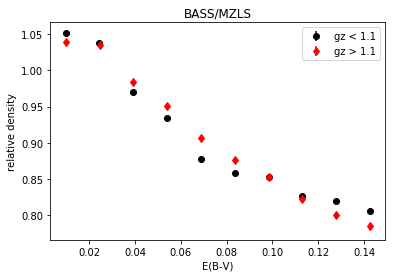

In [150]:
wd = gz[sd1] < 1.1
we = wd & (d1['EBV'] < 0.15)
wen = (wd == 0) & (d1['EBV'] < 0.15)
wr = r1['EBV'] < 0.15
hg1 = np.histogram(d1[we]['EBV'])
hr1 = np.histogram(r1[wr]['EBV'],bins=hg1[1])
hg2 = np.histogram(d1[wen]['EBV'])
hr2 = np.histogram(r1[wr]['EBV'],bins=hg2[1])
xl1 = []
xl2 = []
#print(hg1,hg2)
#print(hr1,hr2)
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
print(xl1,xl2)
norm1 = sum(hr1[0])/sum(hg1[0])
norm2 = sum(hr2[0])/sum(hg2[0])
plt.errorbar(xl1,hg1[0]/hr1[0]*norm1,np.sqrt(hg1[0])/hr1[0]*norm1,fmt='ko')
plt.errorbar(xl2,hg2[0]/hr2[0]*norm2,np.sqrt(hg2[0])/hr2[0]*norm2,fmt='rd')
#plt.ylim(.7,1.3)
plt.xlabel('E(B-V)')
plt.ylabel('relative density')
plt.legend((['gz < 1.1','gz > 1.1']))
plt.title('BASS/MZLS')
plt.show()


[0.013527896883897484, 0.027893331856466832, 0.042258766829036176, 0.056624201801605524, 0.070989636774174872, 0.085355071746744213, 0.099720506719313567, 0.11408594169188291, 0.12845137666445225, 0.14281681163702159] [0.013090420165099204, 0.027501866105012596, 0.041913312044925988, 0.05632475798483938, 0.070736203924752772, 0.085147649864666164, 0.099559095804579556, 0.11397054174449295, 0.12838198768440634, 0.14279343362431973]


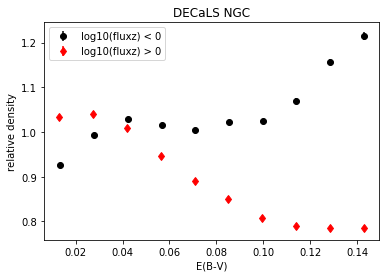

In [113]:
wd = np.log10(d2['FLUX_Z']) < 0
we = wd & (d2['EBV'] < 0.15)
wen = (wd == 0) & (d2['EBV'] < 0.15)
wr = r2['EBV'] < 0.15
hg1 = np.histogram(d2[we]['EBV'])
hr1 = np.histogram(r2[wr]['EBV'],bins=hg1[1])
hg2 = np.histogram(d2[wen]['EBV'])
hr2 = np.histogram(r2[wr]['EBV'],bins=hg2[1])
xl1 = []
xl2 = []
#print(hg1,hg2)
#print(hr1,hr2)
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
print(xl1,xl2)
norm1 = sum(hr1[0])/sum(hg1[0])
norm2 = sum(hr2[0])/sum(hg2[0])
plt.errorbar(xl1,hg1[0]/hr1[0]*norm1,np.sqrt(hg1[0])/hr1[0]*norm1,fmt='ko')
plt.errorbar(xl2,hg2[0]/hr2[0]*norm2,np.sqrt(hg2[0])/hr2[0]*norm2,fmt='rd')
#plt.ylim(.7,1.3)
plt.xlabel('E(B-V)')
plt.ylabel('relative density')
plt.legend((['log10(fluxz) < 0','log10(fluxz) > 0']))
plt.title('DECaLS NGC')
plt.show()

[0.012287968955934047, 0.026783949322998522, 0.041279929690063, 0.055775910057127474, 0.070271890424191949, 0.084767870791256431, 0.099263851158320898, 0.11375983152538538, 0.12825581189244986, 0.14275179225951434] [0.012297340226359666, 0.026792349829338494, 0.041287359432317317, 0.055782369035296146, 0.070277378638274962, 0.084772388241253799, 0.099267397844232635, 0.11376240744721144, 0.12825741705019028, 0.14275242665316912]


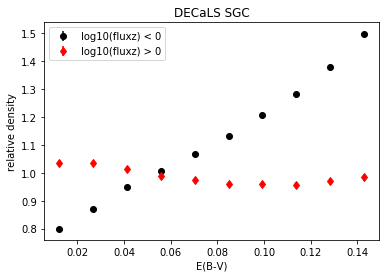

In [112]:
wd = np.log10(d3['FLUX_Z']) < 0
we = wd & (d3['EBV'] < 0.15)
wen = (wd == 0) & (d3['EBV'] < 0.15)
wr = r3['EBV'] < 0.15
hg1 = np.histogram(d3[we]['EBV'])
hr1 = np.histogram(r3[wr]['EBV'],bins=hg1[1])
hg2 = np.histogram(d3[wen]['EBV'])
hr2 = np.histogram(r3[wr]['EBV'],bins=hg2[1])
xl1 = []
xl2 = []
#print(hg1,hg2)
#print(hr1,hr2)
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
print(xl1,xl2)
norm1 = sum(hr1[0])/sum(hg1[0])
norm2 = sum(hr2[0])/sum(hg2[0])
plt.errorbar(xl1,hg1[0]/hr1[0]*norm1,np.sqrt(hg1[0])/hr1[0]*norm1,fmt='ko')
plt.errorbar(xl2,hg2[0]/hr2[0]*norm2,np.sqrt(hg2[0])/hr2[0]*norm2,fmt='rd')
#plt.ylim(.7,1.3)
plt.xlabel('E(B-V)')
plt.ylabel('relative density')
plt.legend((['log10(fluxz) < 0','log10(fluxz) > 0']))
plt.title('DECaLS SGC')
plt.show()

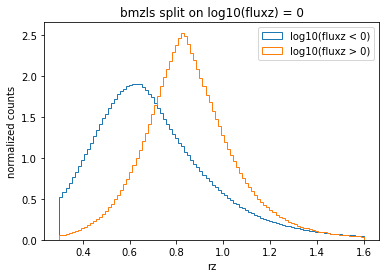

[0.024837483966257422, 0.069842781417537469, 0.11484807886881752, 0.15985337632009758, 0.20485867377137765, 0.24986397122265769, 0.2948692686739377, 0.33987456612521783, 0.38487986357649784, 0.42988516102777796] [0.024823982466477899, 0.069811753125395615, 0.11479952378431334, 0.15978729444323106, 0.2047750651021488, 0.2497628357610665, 0.29475060641998418, 0.33973837707890198, 0.38472614773781966, 0.42971391839673745]


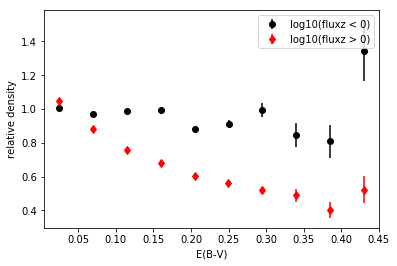

randoms done
2.786157320622839


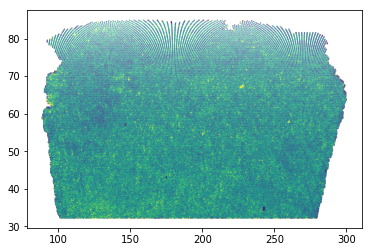

randoms done
0.9296606569545075


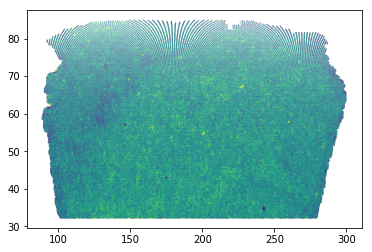

In [65]:
hg1 = np.histogram(d1['GALDEPTH_G']*np.exp(-3.214*d1['EBV']))
hr1 = np.histogram(r1['GALDEPTH_G']*np.exp(-3.214*r1['EBV']),bins=hg1[1])
hg2 = np.histogram(d2['GALDEPTH_G']*np.exp(-3.214*d2['EBV']))
hr2 = np.histogram(r2['GALDEPTH_G']*np.exp(-3.214*r2['EBV']),bins=hg2[1])
hg3 = np.histogram(d3['GALDEPTH_G']*np.exp(-3.214*d3['EBV']))
hr3 = np.histogram(r3['GALDEPTH_G']*np.exp(-3.214*r3['EBV']),bins=hg3[1])

In [61]:
print(hg,hr)

(array([ 126398, 2193458, 7564208, 2410361,  375432,   48624,    6419,
          1128,     131,      19]), array([    0.        ,   180.86185303,   361.72370605,   542.58555908,
         723.44741211,   904.30926514,  1085.17111816,  1266.03297119,
        1446.89482422,  1627.75667725,  1808.61853027])) (array([ 117354, 2024656, 6987273, 2283799,  362883,   47311,    6400,
          1158,     170,      20]), array([    0.        ,   180.86185303,   361.72370605,   542.58555908,
         723.44741211,   904.30926514,  1085.17111816,  1266.03297119,
        1446.89482422,  1627.75667725,  1808.61853027]))


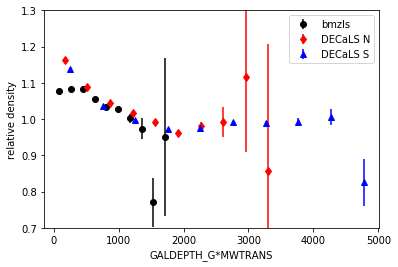

In [75]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
plt.errorbar(xl1,hg1[0]/hr1[0],np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.errorbar(xl2,hg2[0]/hr2[0],np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.errorbar(xl3,hg3[0]/hr3[0],np.sqrt(hg3[0])/hr3[0],fmt='b^')
plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_G*MWTRANS')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.show()

In [76]:
hg1 = np.histogram(d1['GALDEPTH_R']*np.exp(-2.165*d1['EBV']))
hr1 = np.histogram(r1['GALDEPTH_R']*np.exp(-2.165*r1['EBV']),bins=hg1[1])
hg2 = np.histogram(d2['GALDEPTH_R']*np.exp(-2.165*d2['EBV']))
hr2 = np.histogram(r2['GALDEPTH_R']*np.exp(-2.165*r2['EBV']),bins=hg2[1])
hg3 = np.histogram(d3['GALDEPTH_R']*np.exp(-2.165*d3['EBV']))
hr3 = np.histogram(r3['GALDEPTH_R']*np.exp(-2.165*r3['EBV']),bins=hg3[1])

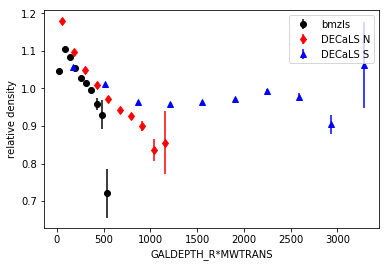

In [78]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
plt.errorbar(xl1,hg1[0]/hr1[0],np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.errorbar(xl2,hg2[0]/hr2[0],np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.errorbar(xl3,hg3[0]/hr3[0],np.sqrt(hg3[0])/hr3[0],fmt='b^')
#plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_R*MWTRANS')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.show()

In [79]:
hg1 = np.histogram(d1['GALDEPTH_Z']*np.exp(-1.211*d1['EBV']))
hr1 = np.histogram(r1['GALDEPTH_Z']*np.exp(-1.211*r1['EBV']),bins=hg1[1])
hg2 = np.histogram(d2['GALDEPTH_Z']*np.exp(-1.211*d2['EBV']))
hr2 = np.histogram(r2['GALDEPTH_Z']*np.exp(-1.211*r2['EBV']),bins=hg2[1])
hg3 = np.histogram(d3['GALDEPTH_Z']*np.exp(-1.211*d3['EBV']))
hr3 = np.histogram(r3['GALDEPTH_Z']*np.exp(-1.211*r3['EBV']),bins=hg3[1])

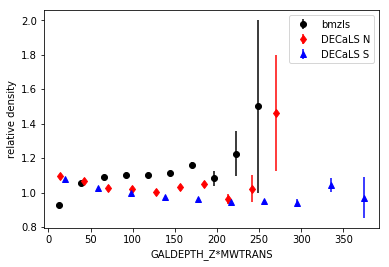

In [80]:
xl1 = []
xl2 = []
xl3 = []
for i in range(0,len(hg1[0])):
    xl1.append((hg1[1][i]+hg1[1][i+1])/2.)
    xl2.append((hg2[1][i]+hg2[1][i+1])/2.)
    xl3.append((hg3[1][i]+hg3[1][i+1])/2.)
plt.errorbar(xl1,hg1[0]/hr1[0],np.sqrt(hg1[0])/hr1[0],fmt='ko')
plt.errorbar(xl2,hg2[0]/hr2[0],np.sqrt(hg2[0])/hr2[0],fmt='rd')
plt.errorbar(xl3,hg3[0]/hr3[0],np.sqrt(hg3[0])/hr3[0],fmt='b^')
#plt.ylim(.7,1.3)
plt.xlabel('GALDEPTH_Z*MWTRANS')
plt.ylabel('relative density')
plt.legend((['bmzls','DECaLS N','DECaLS S']))
plt.show()

In [53]:
def get_pixkey(hppix,key):
    return fitsio.read(pixfn,columns=key)[hppix]

In [40]:
frelg = fitsio.read('/global/cscratch1/sd/raichoor/desits_lss/dr8-0.31.1/lss-dr8-0.31.1-elg.rand.fits',rows=np.arange(1e6))
frelgh = fitsio.read_header('/global/cscratch1/sd/raichoor/desits_lss/dr8-0.31.1/lss-dr8-0.31.1-elg.rand.fits',ext=1)
frelgh


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / array data type
NAXIS   =                    2 / number of array dimensions
NAXIS1  =                   85 / length of dimension 1
NAXIS2  =            304987125 / length of dimension 2
PCOUNT  =                    0 / number of group parameters
GCOUNT  =                    1 / number of groups
TFIELDS =                   21 / number of table fields
TTYPE1  = 'RA      '
TFORM1  = 'D       '
TTYPE2  = 'DEC     '
TFORM2  = 'D       '
TTYPE3  = 'BRICKNAME'
TFORM3  = '8A      '
TTYPE4  = 'NOBS_G  '
TFORM4  = 'I       '
TTYPE5  = 'NOBS_R  '
TFORM5  = 'I       '
TTYPE6  = 'NOBS_Z  '
TFORM6  = 'I       '
TTYPE7  = 'PSFDEPTH_G'
TFORM7  = 'E       '
TTYPE8  = 'PSFDEPTH_R'
TFORM8  = 'E       '
TTYPE9  = 'PSFDEPTH_Z'
TFORM9  = 'E       '
TTYPE10 = 'GALDEPTH_G'
TFORM10 = 'E       '
TTYPE11 = 'GALDEPTH_R'
TFORM11 = 'E       '
TTYPE12 = 'GALDEPTH_Z'
TFORM12 = 'E       '
TTYPE13 = 'PSFDEPTH_W1'
TFORM13 = 'E     

In [41]:
print(len(frelg['RA']))
np.unique(frelg['RA'])


1000000


array([ 27.93674158,  99.11682193])

In [42]:
rall = fitsio.read('/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randomsall/randoms-inside-dr8-0.31.0-all.fits',rows=np.arange(1e6)
                  )
rall_header = fitsio.read_header('/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randomsall/randoms-inside-dr8-0.31.0-all.fits',ext=1)

In [43]:
rall_header


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / 8-bit bytes
NAXIS   =                    2 / 2-dimensional binary table
NAXIS1  =                  115 / width of table in bytes
NAXIS2  =            508311875 / number of rows in table
PCOUNT  =                    0 / size of special data area
GCOUNT  =                    1 / one data group (required keyword)
TFIELDS =                   29 / number of fields in each row
TTYPE1  = 'RA      '           / label for field   1
TFORM1  = 'D       '           / data format of field: 8-byte DOUBLE
TTYPE2  = 'DEC     '           / label for field   2
TFORM2  = 'D       '           / data format of field: 8-byte DOUBLE
TTYPE3  = 'BRICKNAME'          / label for field   3
TFORM3  = '8A      '           / data format of field: ASCII Character
TTYPE4  = 'NOBS_G  '           / label for field   4
TFORM4  = 'I       '           / data format of field: 2-byte INTEGER
TTYPE5  = 'NOBS_R  '           / label for fi

In [37]:
np.unique(rall['RA'])


array([  3.66742491e-04,   1.67202641e-03,   1.80935813e-03, ...,
         3.59998970e+02,   3.59998992e+02,   3.59999299e+02])

In [44]:
frelg = fitsio.read('/global/cscratch1/sd/raichoor/desits_lss/dr8-0.31.1/lss-dr8-0.31.1-elg.rand.fits',rows=np.arange(1e6))


In [45]:
np.unique(frelg['RA'])

array([ 27.93674158,  99.11682193])

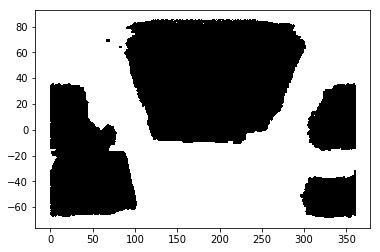

In [46]:
plt.plot(rall['RA'],rall['DEC'],'k,')
plt.show()

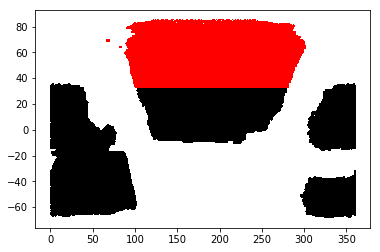

In [54]:
plt.plot(rall['RA'],rall['DEC'],'k,')
plt.plot(rall[NN]['RA'],rall[NN]['DEC'],'r,')
plt.show()

In [48]:
np.unique(rall['PHOTSYS'])

array([b'N', b'S'],
      dtype='|S1')

In [52]:
NN = rall['PHOTSYS'] == b'N'

In [53]:
len(rall[NN])

253496

In [55]:
d1 = (rall['PHOTSYS'] != b'N') & (rall['RA'] < 300) & (rall['RA'] > 100) & (rall['DEC'] > -20)

In [56]:
len(rall[d1])

292442

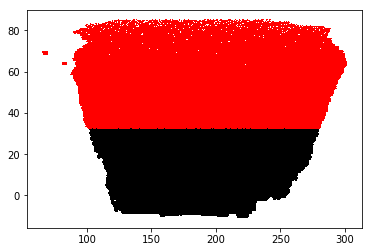

In [57]:
plt.plot(rall[d1]['RA'],rall[d1]['DEC'],'k,')
plt.plot(rall[NN]['RA'],rall[NN]['DEC'],'r,')
plt.show()

In [58]:
d2 = (d1==0) & (NN ==0) 

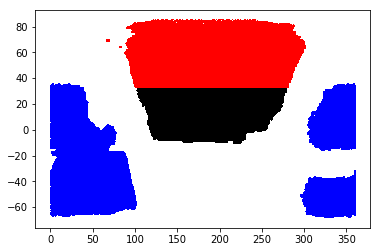

In [59]:
plt.plot(rall[d1]['RA'],rall[d1]['DEC'],'k,')
plt.plot(rall[NN]['RA'],rall[NN]['DEC'],'r,')
plt.plot(rall[d2]['RA'],rall[d2]['DEC'],'b,')
plt.show()

In [60]:
keep = (rall['NOBS_G']>0) & (rall['NOBS_R']>0) & (rall['NOBS_Z']>0)
print(len(rall[keep]))
elgbits = [1,5,6,7,11,12,13]
keepelg = keep
for bit in elgbits:
    keepelg &= ((rall['MASKBITS'] & 2**bit)==0)
print(len(rall[keepelg]))    

956051
910853


In [61]:
rall = fitsio.read('/project/projectdirs/desi/target/catalogs/dr8/0.31.0/randomsall/randoms-inside-dr8-0.31.0-all.fits',rows=np.arange(1e7)
                  )


In [62]:
keep = (rall['NOBS_G']>0) & (rall['NOBS_R']>0) & (rall['NOBS_Z']>0)
print(len(rall[keep]))
elgbits = [1,5,6,7,11,12,13]
keepelg = keep
for bit in elgbits:
    keepelg &= ((rall['MASKBITS'] & 2**bit)==0)
print(len(rall[keepelg]))    

9559654
9109322


In [63]:
felg = fitsio.read('/global/cscratch1/sd/raichoor/desits_lss/dr8-0.31.1/lss-dr8-0.31.1-elg.data.fits')

In [96]:
len(np.unique(felg['RA']))
keepe = (felg['NOBS_G']>0) & (felg['NOBS_R']>0) & (felg['NOBS_Z']>0)
print(len(felg[keepe]))
elgbits = [1,5,6,7,11,12,13]
keepelge = keepe
for bit in elgbits:
    keepelge &= ((felg['MASKBITS'] & 2**bit)==0)
print(len(felg[keepelge]))  

In [99]:
print(len(felg))
print(len(felg[keepelge])) 

47256516
47255413


In [65]:
relg = rall[keepelg]

In [68]:
import healpy
def radec2thphi(ra,dec):
    return (-dec+90.)*np.pi/180.,ra*np.pi/180.

In [71]:
rth,rphi = radec2thphi(relg['RA'],relg['DEC'])
rpix = healpy.ang2pix(256,rth,rphi)

In [72]:
dth,dphi = radec2thphi(felg['RA'],felg['DEC'])
dpix = healpy.ang2pix(256,dth,dphi)

In [73]:
print(len(np.unique(rpix)),len(np.unique(dpix)))

377277 377786


In [74]:
pixlr = np.zeros(12*256*256)
pixlg = np.zeros(12*256*256)


In [78]:

for pix in rpix:
    pixlr[pix] += 1.
print('randoms done')
for pix in dpix:
    pixlg[pix] += 1.


randoms done


In [79]:
mg = len(dth)/float(len(relg))
print(mg)

5.187709469486313


In [83]:
wp = pixlr > 0
pixls = []
for i in range(0,len(pixlr)):
    if pixlr[i] > 0:
        pixls.append(i)
pixls = np.array(pixls).astype(int)        
th,phi = healpy.pix2ang(256,pixls)
od = pixlg[wp]/pixlr[wp]/mg

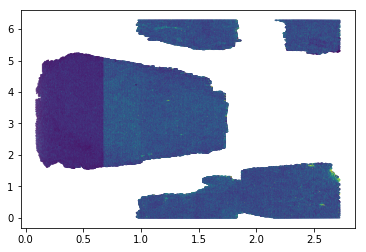

In [89]:
plt.scatter(th,phi,c=od,vmax=4,s=.1)
plt.show()

In [85]:
np.max(od)

17.348697055872677

In [86]:
np.min(od)

0.0

In [93]:
def thphi2radec(theta,phi):
    return 180./np.pi*phi,-(180./np.pi*theta-90)


In [94]:
ra,dec = thphi2radec(th,phi)

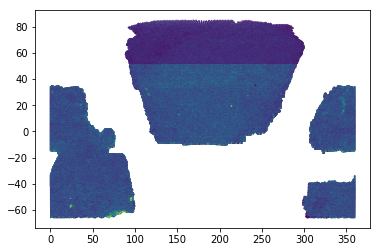

In [95]:
plt.scatter(ra,dec,c=od,vmax=4,s=.1)
plt.show()

In [102]:
frelg = fitsio.read('/global/cscratch1/sd/raichoor/desits_lss/dr8-0.31.1/lss-dr8-0.31.1-elg.rand.fits',rows=np.arange(5e7))

In [103]:
rth,rphi = radec2thphi(frelg['RA'],frelg['DEC'])
rpix = healpy.ang2pix(256,rth,rphi)

In [104]:
pixlr = np.zeros(12*256*256)
for pix in rpix:
    pixlr[pix] += 1.

In [105]:
mg = len(dth)/float(len(frelg))
print(mg)

0.94513032


In [106]:
wp = pixlr > 0
pixls = []
for i in range(0,len(pixlr)):
    if pixlr[i] > 0:
        pixls.append(i)
pixls = np.array(pixls).astype(int)        
th,phi = healpy.pix2ang(256,pixls)
od = pixlg[wp]/pixlr[wp]/mg

In [107]:
ra,dec = thphi2radec(th,phi)

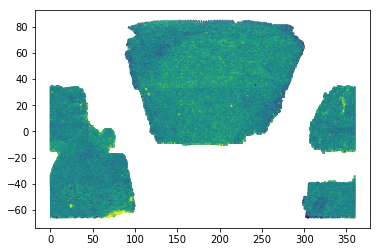

In [109]:
plt.scatter(ra,dec,c=od,vmax=2,s=.1)
plt.show()

In [110]:
felg_header = fitsio.read_header('/global/cscratch1/sd/raichoor/desits_lss/dr8-0.31.1/lss-dr8-0.31.1-elg.data.fits',ext=1)

In [111]:
felg_header


XTENSION= 'BINTABLE'           / binary table extension
BITPIX  =                    8 / array data type
NAXIS   =                    2 / number of array dimensions
NAXIS1  =                   85 / length of dimension 1
NAXIS2  =             47256516 / length of dimension 2
PCOUNT  =                    0 / number of group parameters
GCOUNT  =                    1 / number of groups
TFIELDS =                   21 / number of table fields
TTYPE1  = 'RA      '
TFORM1  = 'D       '
TTYPE2  = 'DEC     '
TFORM2  = 'D       '
TTYPE3  = 'BRICKNAME'
TFORM3  = '8A      '
TTYPE4  = 'NOBS_G  '
TFORM4  = 'I       '
TTYPE5  = 'NOBS_R  '
TFORM5  = 'I       '
TTYPE6  = 'NOBS_Z  '
TFORM6  = 'I       '
TTYPE7  = 'PSFDEPTH_G'
TFORM7  = 'E       '
TTYPE8  = 'PSFDEPTH_R'
TFORM8  = 'E       '
TTYPE9  = 'PSFDEPTH_Z'
TFORM9  = 'E       '
TTYPE10 = 'GALDEPTH_G'
TFORM10 = 'E       '
TTYPE11 = 'GALDEPTH_R'
TFORM11 = 'E       '
TTYPE12 = 'GALDEPTH_Z'
TFORM12 = 'E       '
TTYPE13 = 'PSFDEPTH_W1'
TFORM13 = 'E     

In [116]:
def splitcat(cat):
    NN = cat['PHOTSYS'] == b'N'
    d1 = (cat['PHOTSYS'] != b'N') & (cat['RA'] < 300) & (cat['RA'] > 100) & (cat['DEC'] > -20)
    d2 = (d1==0) & (NN ==0) & (cat['DEC'] > -30)
    return cat[NN],cat[d1],cat[d2]

    

In [141]:
d1,d2,d3 = splitcat(felg)

In [118]:
r1,r2,r3 = splitcat(frelg)

In [119]:
print(len(d1)/len(r1),len(d2)/len(r2),len(d3)/len(r3))

0.9792356620851657 0.9568925930622876 0.9218958060674937


In [124]:
lsd = np.log(r1['STARDENS'])
r1hist = np.histogram(lsd)

In [125]:
r1hist

(array([   1572,   45298, 1029999, 4151863, 3383472, 2383190, 1353694,
         632237,   14696,      11]),
 array([ 4.33407784,  4.83001204,  5.32594624,  5.82188044,  6.31781464,
         6.81374884,  7.30968304,  7.80561724,  8.30155144,  8.79748564,
         9.29341984]))

In [126]:
lsdd = np.log(d1['STARDENS'])
d1hist = np.histogram(lsdd,bins=r1hist[1])

In [127]:
d1hist

(array([   1601,   48043, 1082328, 4288532, 3296875, 2226268, 1233304,
         537707,   11515,       5]),
 array([ 4.33407784,  4.83001204,  5.32594624,  5.82188044,  6.31781464,
         6.81374884,  7.30968304,  7.80561724,  8.30155144,  8.79748564,
         9.29341984]))

In [129]:
xl = []
for i in range(0,10):
    xl.append((d1hist[1][i]+d1hist[1][i+1])/2.)

<Container object of 3 artists>

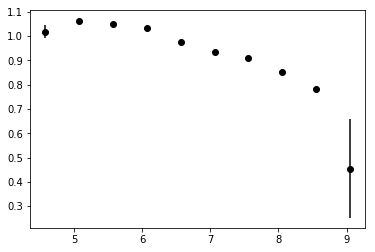

In [138]:
plt.errorbar(xl,d1hist[0]/r1hist[0],d1hist[0]**.5/r1hist[0],fmt='ko')

In [131]:
lsd = np.log(r2['STARDENS'])
r2hist = np.histogram(lsd)
lsdd = np.log(d2['STARDENS'])
d2hist = np.histogram(lsdd,bins=r2hist[1])

<Container object of 3 artists>

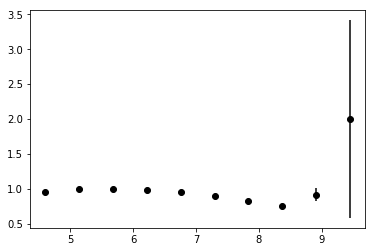

In [139]:
xl = []
for i in range(0,10):
    xl.append((d2hist[1][i]+d2hist[1][i+1])/2.)
plt.errorbar(xl,d2hist[0]/r2hist[0],d2hist[0]**.5/r2hist[0],fmt='ko')

In [133]:
lsd = np.log(r3['STARDENS'])
r3hist = np.histogram(lsd)
lsdd = np.log(d3['STARDENS'])
d3hist = np.histogram(lsdd,bins=r3hist[1])

<Container object of 3 artists>

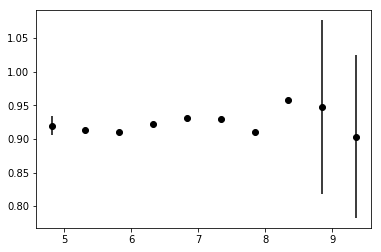

In [140]:
xl = []
for i in range(0,10):
    xl.append((d3hist[1][i]+d3hist[1][i+1])/2.)
plt.errorbar(xl,d3hist[0]/r3hist[0],d3hist[0]**.5/r3hist[0],fmt='ko')

In [135]:
r3hist[1]

array([ 4.55722141,  5.06207867,  5.56693592,  6.07179317,  6.57665043,
        7.08150768,  7.58636494,  8.09122219,  8.59607944,  9.1009367 ,
        9.60579395])

In [1]:
r3hist[1]

NameError: name 'r3hist' is not defined